# Prepare

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr
import datetime
import time
import itertools
import pickle

from VariationalNC.utils import *
from VariationalNC.train import *
from VariationalNC.Variational_layers import VariationalLinear, VariationalConv2d
from VariationalNC.Variational_utils import variational_estimator, ScaleMixtureGaussian
import VariationalNC.activation_max_utils as amu

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# for plot figures
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
class VanillaCNN(nn.Module):
    def __init__(self,numoffea=48):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=161 #number of neurons
        #
        self.conv1 = nn.Conv2d(2,48,kernel_size=9,stride=1)#24,23*23
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(48,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(48*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = F.relu(self.conv1(x))#24,23*23
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded)) #use exp instead of relu
        return encoded
    
@variational_estimator
class VariationalCNN(nn.Module):
    def __init__(self,numoffea=48,PI=0.5, SIGMA_1=1, SIGMA_2=0.00247875):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=161 #number of neurons
        self.conv1=VariationalConv2d(2,48,kernel_size=(9,9),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#24,23*23
        self.conv2=VariationalConv2d(48,self.numoffea,kernel_size=(7,7),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#48,17*17
        self.fc1  =VariationalLinear(self.numoffea*self.sizeoffea,self.numofneuron,PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)
    def forward(self, x, sampleFlag=False):
        encoded = F.relu(self.conv1(x, sampleFlag))#24,23*23
        encoded = F.relu(self.conv2(encoded, sampleFlag))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded, sampleFlag)) #use exp instead of relu
        return encoded

In [3]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
train_std = torch.from_numpy(np.array([0.23363489, 0.24817178])[None,:,None,None]).float()
# print (train_std.shape)

In [4]:
def act_max_pack(
    tempmodel, # model
    train_std, # torch.tensor, from the training data
    unit,         # neuron id
    inputseed = 1,  # for input_img
    sampleFlag=False, # for variational model
    sampleseed=1,     # for variational model
    device=device_cpu,    # only test cpu for now
):
    """
    Activation max, packed function.
    Output: torch.tensor, with a shape of (1, c, h, w), with a std equals to train_std
    """
    tempmodel = tempmodel.to(device)  
    for param in tempmodel.parameters():
        param.requires_grad = False
    tempmodel = tempmodel.eval()
    # for param in tempmodel.parameters():
    #     print (param)
    
    # input_img, should have a shape of (1, c, h, w)
    torch.manual_seed(inputseed)    # reproducible
    input_img = torch.randn(1, 2, 36, 64) * train_std
    
    # model.fc1
    activation_dictionary = {}
    layer_name = 'fc1'
    tempmodel.fc1.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

    # config for activation maximization
    steps = 100                 # perform 100 iterations
    # unit = 95                  # flamingo class of Imagenet
    alpha = torch.tensor(10)   # learning rate (step size) 
    verbose = False              # print activation every step
    L2_Decay = True             # enable L2 decay regularizer
    Gaussian_Blur = True        # enable Gaussian regularizer
    Norm_Crop = True            # enable norm regularizer
    Contrib_Crop = True         # enable contribution regularizer
    # sampleFlag=False          # for variational model
    # sampleseed=4              # for variational model
    
    output = amu.act_max(network=tempmodel,
                input=input_img,
                layer_activation=activation_dictionary,
                layer_name=layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                verbose=verbose,
                L2_Decay=L2_Decay,
                Gaussian_Blur=Gaussian_Blur,
                Norm_Crop=Norm_Crop,
                Contrib_Crop=Contrib_Crop,
                sampleFlag=sampleFlag,
                sampleseed=sampleseed,
                )
    
    # keep the mean and the std consistent with training data (mean is equal to zeros)
    # output image has the same shape with the input
    output = output - torch.mean(output, dim=(2,3), keepdims=True)
    output = output/torch.std(output, dim=(2,3), keepdims=True)*train_std
    # print (torch.std(output))
    return output


In [5]:
#https://stats.stackexchange.com/questions/65831/permutation-test-comparing-a-single-sample-against-a-mean
#https://netneurotools.readthedocs.io/en/latest/_modules/netneurotools/stats.html#permtest_1samp
def oneSamp_perm_test(xs, popmean, nmc, randomseed,alternative='two-sided'):
    """
    Generates two-tailed p-value for hypothesis of whether `xs` differs from
    `popmean` using permutation tests
    """
    n, k = len(xs), 0
    # center `xs` around `popmean` and calculate original mean
    zeroed = xs - popmean
    true_mean= np.mean(zeroed)
    abs_mean = np.abs(true_mean)
    for j in range(nmc):
        np.random.seed(randomseed+j)
        flipped = zeroed * np.random.choice([-1, 1], size=zeroed.shape)  # sign flip
        #k += abs_mean <= np.abs(np.mean(flipped))
        if alternative=='two-sided':
            k += abs_mean <= np.abs(np.mean(flipped))
        elif alternative=='greater':
            k += true_mean <= np.mean(flipped)
        elif alternative=='less':
            k += true_mean >= np.mean(flipped)
    return k / nmc

# one unit

In [12]:
# one model-VanillaCNN, one unit, one inputseed
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
# tempmodels=['VariationalCNN'] 
# model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
# tempmodel = globals()[tempmodels[0]](**model_parameters)
# torch.manual_seed(1)    # reproducible
# torch.cuda.manual_seed(1)
# tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

unit = 95
inputseed = 1
sampleFlag = False
sampleseed = 1
output = act_max_pack(
    tempmodel = tempmodel, # model
    train_std = train_std, # torch.tensor, from the training data
    unit = unit,             # neuron id
    inputseed = inputseed,   # for input_img
    sampleFlag = sampleFlag,      # for variational model
    sampleseed = sampleseed,      # for variational model
)
outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

# test activation
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
tempmodel = tempmodel.to(device_cpu) 
tempmodel = tempmodel.eval()
outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
# simple plot
# plt.imshow(output.cpu().data.numpy()[0,0])

outs.shape: (1, 161). Neuron 95 activation: 5.514772891998291
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.366104125976562


outs.shape: (1, 161). Neuron 95 activation: 8.139802932739258
Test activation: outs.shape: (1, 161). Neuron 95 activation: 11.464073181152344


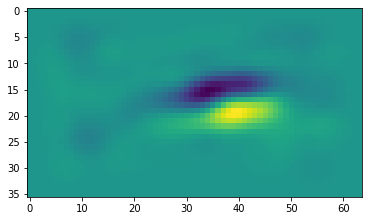

In [21]:
# one model-VariationalCNN-sampleFlag=False, one unit, one inputseed
# tempmodel= VanillaCNN()   #with regularization
# tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

unit = 95
inputseed = 1
sampleFlag = False
sampleseed = 1
output = act_max_pack(
    tempmodel = tempmodel, # model
    train_std = train_std, # torch.tensor, from the training data
    unit = unit,             # neuron id
    inputseed = inputseed,   # for input_img
    sampleFlag = sampleFlag,      # for variational model
    sampleseed = sampleseed,      # for variational model
)
outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

# test activation
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
tempmodel = tempmodel.to(device_cpu) 
tempmodel = tempmodel.eval()
outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
# simple plot
plt.imshow(output.cpu().data.numpy()[0,0])

## Variational-sampleFlag=True

In [32]:
# one model-Variational-sampleFlag=True, one unit, one inputseed
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

unit = 95
inputseed = 1
sampleFlag = True
sampleseeds = np.arange(100).tolist()
tempoutputs = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())

tempoutputs = np.array(tempoutputs)
print (f'tempoutputs.shape: {tempoutputs.shape}')

tempoutputs.shape: (100, 1, 2, 36, 64)


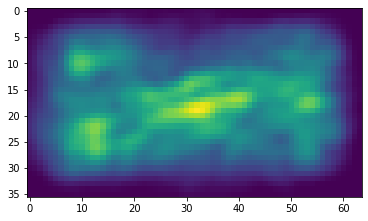

In [33]:
plt.imshow(np.std(tempoutputs, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


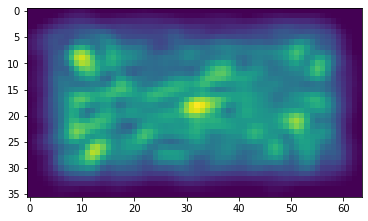

In [16]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


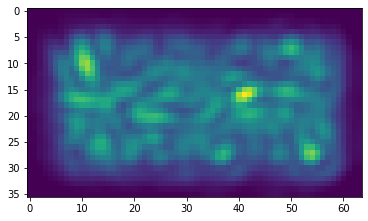

In [17]:
i=2
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


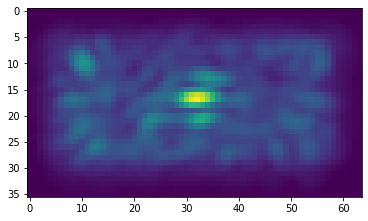

In [14]:
i=3
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


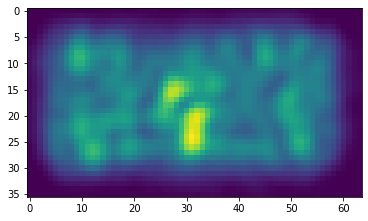

In [19]:
i=3
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


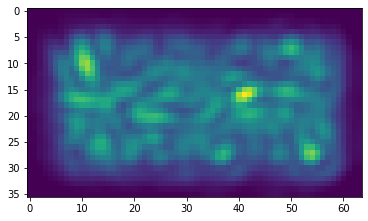

In [18]:
i=2
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

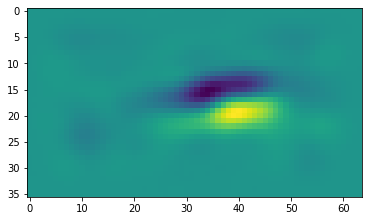

In [34]:
plt.imshow(np.mean(tempoutputs, axis=0)[0,0])

In [36]:
#np.save('out_20220423/YQactivation-max-outputs-manysamples-VariationalCNN_Franke2021.npy', tempoutputs)

# multiple units

## vanilla

In [17]:
# one model, all neurons, 5 inputseeds
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

units = np.arange(161).tolist()
inputseeds = np.arange(1,6).tolist()
sampleFlag = False
sampleseed = 1

# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

outputs = [] # numpy array
acts = np.ones(len(units)) * (-np.inf)
for ii,unit in enumerate(units):
    tempoutputs = []
    tempacts = np.ones(len(inputseeds)) * (-np.inf)
    for jj,inputseed in enumerate(inputseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput)
        tempacts[jj] = np.log(tempmodel( tempoutput ).cpu().data.numpy())[0, unit]
    # selected the output image with largest activations based on original tempmodel
    tempbestoutput = tempoutputs[np.argmax(tempacts)] 
    outputs.append(tempbestoutput.cpu().data.numpy())
    
    # test activation
    acts[ii] = np.log(testmodel( tempbestoutput ).cpu().data.numpy())[0, unit] # cancel out the last layer - exp layer

outputs_rcnn = np.array(outputs)
acts_rcnn = np.copy(acts)

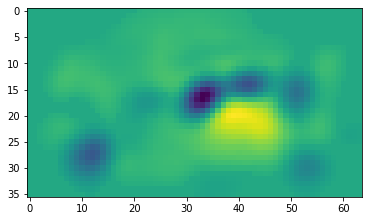

In [20]:
plt.imshow(outputs_rcnn[95][0,0])

In [18]:
acts_rcnn[95]

9.366104125976562

In [37]:
#np.save('out_20220423/YQactivation-max-many-neurons-outputs_rcnn_Franke2021.npy', outputs_rcnn)
#np.save('out_20220423/YQactivation-max-many-neurons-acts_rcnn_Franke2021.npy', acts_rcnn)

## variation-sampleFlag=False

In [22]:
# one model-variation-sampleFlag=False, all neurons, 5 inputseeds
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

units = np.arange(161).tolist()
inputseeds = np.arange(1,6).tolist()
sampleFlag = False
sampleseed = 1

# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

outputs = [] # numpy array
acts = np.ones(len(units)) * (-np.inf)
for ii,unit in enumerate(units):
    tempoutputs = []
    tempacts = np.ones(len(inputseeds)) * (-np.inf)
    for jj,inputseed in enumerate(inputseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput)
        tempacts[jj] = np.log(tempmodel( tempoutput ).cpu().data.numpy())[0, unit]
    # selected the output image with largest activations based on original tempmodel
    tempbestoutput = tempoutputs[np.argmax(tempacts)] 
    outputs.append(tempbestoutput.cpu().data.numpy())
    
    # test activation
    acts[ii] = np.log(testmodel( tempbestoutput ).cpu().data.numpy())[0, unit] # cancel out the last layer - exp layer

outputs_vcnn = np.array(outputs)
acts_vcnn = np.copy(acts)

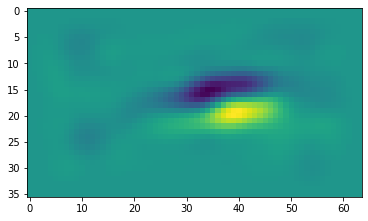

In [23]:
plt.imshow(outputs_vcnn[95][0,0])

# example unit-40%

## Vanilla

In [5]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 95
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron95-acts_seed_'+str(i)+'_rcnn_Franke2021.npy', out_rcnn)

outs.shape: (1, 161). Neuron 95 activation: 5.503810882568359
Test activation: outs.shape: (1, 161). Neuron 95 activation: 6.319622993469238
outs.shape: (1, 161). Neuron 95 activation: 7.812444686889648
Test activation: outs.shape: (1, 161). Neuron 95 activation: 8.1354341506958
outs.shape: (1, 161). Neuron 95 activation: 5.719002723693848
Test activation: outs.shape: (1, 161). Neuron 95 activation: 6.544727802276611
outs.shape: (1, 161). Neuron 95 activation: 7.316933631896973
Test activation: outs.shape: (1, 161). Neuron 95 activation: 8.576348304748535
outs.shape: (1, 161). Neuron 95 activation: 7.854127407073975
Test activation: outs.shape: (1, 161). Neuron 95 activation: 8.375795364379883


In [6]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 123
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron123-acts_seed_'+str(i)+'_rcnn_Franke2021.npy', out_rcnn)

outs.shape: (1, 161). Neuron 123 activation: 8.581790924072266
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.652631759643555
outs.shape: (1, 161). Neuron 123 activation: 8.730451583862305
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.262657165527344
outs.shape: (1, 161). Neuron 123 activation: 8.41147232055664
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.18755054473877
outs.shape: (1, 161). Neuron 123 activation: 10.560774803161621
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.853558540344238
outs.shape: (1, 161). Neuron 123 activation: 9.040478706359863
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.805789947509766


In [7]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 22
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron22-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron22-acts_seed_'+str(i)+'_rcnn_Franke2021.npy', out_rcnn)

outs.shape: (1, 161). Neuron 22 activation: 3.881894826889038
Test activation: outs.shape: (1, 161). Neuron 22 activation: 5.533270359039307
outs.shape: (1, 161). Neuron 22 activation: 5.098439693450928
Test activation: outs.shape: (1, 161). Neuron 22 activation: 5.712034225463867
outs.shape: (1, 161). Neuron 22 activation: 4.319263935089111
Test activation: outs.shape: (1, 161). Neuron 22 activation: 6.1652045249938965
outs.shape: (1, 161). Neuron 22 activation: 4.6843132972717285
Test activation: outs.shape: (1, 161). Neuron 22 activation: 5.14535665512085
outs.shape: (1, 161). Neuron 22 activation: 5.504675388336182
Test activation: outs.shape: (1, 161). Neuron 22 activation: 6.111056804656982


In [8]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 106
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron106-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron106-acts_seed_'+str(i)+'_rcnn_Franke2021.npy', out_rcnn)

outs.shape: (1, 161). Neuron 106 activation: 5.660498142242432
Test activation: outs.shape: (1, 161). Neuron 106 activation: 8.132476806640625
outs.shape: (1, 161). Neuron 106 activation: 7.239170551300049
Test activation: outs.shape: (1, 161). Neuron 106 activation: 7.252812385559082
outs.shape: (1, 161). Neuron 106 activation: 5.828263759613037
Test activation: outs.shape: (1, 161). Neuron 106 activation: 7.48495626449585
outs.shape: (1, 161). Neuron 106 activation: 9.964876174926758
Test activation: outs.shape: (1, 161). Neuron 106 activation: 9.893086433410645
outs.shape: (1, 161). Neuron 106 activation: 9.331400871276855
Test activation: outs.shape: (1, 161). Neuron 106 activation: 8.012163162231445


(1, 2, 36, 64)


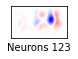

In [68]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/trainnum_1_RFs_with_std_rCNN_channel0_neuron123_activation_max.svg')

(1, 2, 36, 64)


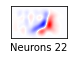

In [69]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron22-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 22')
#fig.savefig('out_result_20220423/trainnum_1_RFs_with_std_rCNN_channel0_neuron22_activation_max.svg')

(1, 2, 36, 64)


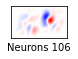

In [70]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron106-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 106')
#fig.savefig('out_result_20220423/trainnum_1_RFs_with_std_rCNN_channel0_neuron106_activation_max.svg')

## variation-sampleFlag=False

In [9]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 95
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', out_vcnn)

outs.shape: (1, 161). Neuron 95 activation: 9.759769439697266
Test activation: outs.shape: (1, 161). Neuron 95 activation: 11.015864372253418
outs.shape: (1, 161). Neuron 95 activation: 5.752151012420654
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.088423728942871
outs.shape: (1, 161). Neuron 95 activation: 5.964657783508301
Test activation: outs.shape: (1, 161). Neuron 95 activation: 8.912116050720215
outs.shape: (1, 161). Neuron 95 activation: 6.259171962738037
Test activation: outs.shape: (1, 161). Neuron 95 activation: 8.667213439941406
outs.shape: (1, 161). Neuron 95 activation: 9.312965393066406
Test activation: outs.shape: (1, 161). Neuron 95 activation: 10.505236625671387


In [11]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 123
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', out_vcnn)

outs.shape: (1, 161). Neuron 123 activation: 11.121233940124512
Test activation: outs.shape: (1, 161). Neuron 123 activation: 10.710111618041992
outs.shape: (1, 161). Neuron 123 activation: 7.823999404907227
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.9947509765625
outs.shape: (1, 161). Neuron 123 activation: 7.816550254821777
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.957073211669922
outs.shape: (1, 161). Neuron 123 activation: 10.669464111328125
Test activation: outs.shape: (1, 161). Neuron 123 activation: 10.554572105407715
outs.shape: (1, 161). Neuron 123 activation: 10.369471549987793
Test activation: outs.shape: (1, 161). Neuron 123 activation: 10.633359909057617


In [12]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 22
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron22-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', out_vcnn)

outs.shape: (1, 161). Neuron 22 activation: 6.263054847717285
Test activation: outs.shape: (1, 161). Neuron 22 activation: 6.858633518218994
outs.shape: (1, 161). Neuron 22 activation: 4.097754955291748
Test activation: outs.shape: (1, 161). Neuron 22 activation: 5.771997928619385
outs.shape: (1, 161). Neuron 22 activation: 4.206591606140137
Test activation: outs.shape: (1, 161). Neuron 22 activation: 5.978275299072266
outs.shape: (1, 161). Neuron 22 activation: 5.672380447387695
Test activation: outs.shape: (1, 161). Neuron 22 activation: 6.276394844055176
outs.shape: (1, 161). Neuron 22 activation: 6.34341287612915
Test activation: outs.shape: (1, 161). Neuron 22 activation: 6.5115556716918945


In [13]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 106
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron106-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20220423/trainnum_1_activation-max-example-neuron106-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', out_vcnn)

outs.shape: (1, 161). Neuron 106 activation: 9.884328842163086
Test activation: outs.shape: (1, 161). Neuron 106 activation: 10.315205574035645
outs.shape: (1, 161). Neuron 106 activation: 4.963329792022705
Test activation: outs.shape: (1, 161). Neuron 106 activation: 7.674508094787598
outs.shape: (1, 161). Neuron 106 activation: 5.122219562530518
Test activation: outs.shape: (1, 161). Neuron 106 activation: 8.537734985351562
outs.shape: (1, 161). Neuron 106 activation: 7.869799613952637
Test activation: outs.shape: (1, 161). Neuron 106 activation: 9.531898498535156
outs.shape: (1, 161). Neuron 106 activation: 10.195375442504883
Test activation: outs.shape: (1, 161). Neuron 106 activation: 10.607152938842773


(1, 2, 36, 64)


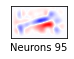

In [25]:
i=3
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/trainnum_1_RFs_VCNN_channel0_neuron95_activation_max.svg')

In [108]:
i=3
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
data=RF_fl_np[:,0,0]
print(data.shape)

(100, 36, 64)


In [28]:
mask=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        temp=oneSamp_perm_test(data[:,ii,jj], 0, 10000, 66)
        print(temp)
        mask[ii,jj]=temp
#np.save('out_20220423/trainnum_1_activation-max-example-neuron95-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy', mask)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0001
0.004
0.0303
0.0037
0.0003
0.0
0.0
0.0
0.0026
0.1478
0.3632
0.5382
0.4991
0.8351
0.7045
0.5546
0.7629
0.678
0.5416
0.6046
0.8074
0.3455
0.0025
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0004
0.0028
0.0061
0.0325
0.0641
0.1044
0.0307
0.0036
0.0006
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0001
0.0194
0.0528
0.1299
0.323
0.7177
0.9111
0.7135
0.8744
0.9507
0.722
0.221
0.9447
0.0749
0.0031
0.0005
0.0001
0.0002
0.0007
0.0065
0.0097
0.0033
0.0012
0.0007
0.0021
0.0075
0.143
0.8933
0.0214
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0013
0.4876
0.8233
0.8343
0.9113
0.9552
0.6752
0.6127
0.8871
0.6649
0.3388
0.073
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0016
0.2149
0.7046
0.1516
0.3281
0.5818
0.3605
0.1154
0.1509
0.0429
0.0134
0.0151
0.0299
0.0163
0.0012
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0001
0.0003
0.0001
0.0001
0.0
0.0027
0.0421
0.9701
0.1252


In [36]:
i=3
mask=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy')

In [37]:
thre=0.01
mask_thre=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        if mask[ii,jj]<thre:
            mask_thre[ii,jj]=0
        else:
            mask_thre[ii,jj]=1      

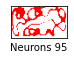

In [39]:
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
tempmax=np.max(np.abs(mask_thre))
#axes.imshow(mask_thre,vmin=0,vmax=1,cmap='gray')
axes.imshow(mask_thre,vmin=-1,vmax=1,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/trainnum_1_fig2_RFs_vCNN_gray_channel0_neuron95_perm_test.svg')

(1, 2, 36, 64)
(36, 64)


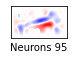

In [113]:
i=3
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#mask=np.load('out_20220423/activation-max-example-neuron95-perm_test_mask_seed_35_vcnn_Franke2021.npy')
print (RF_fl_np.shape)
print(mask_thre.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]*mask_thre
tempmax=np.max(np.abs(temp))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/trainnum_1_RFs_VCNN_channel0_neuron95_activation_max_perm_test.svg')

(100, 1, 2, 36, 64)
(1, 2, 36, 64)


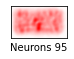

In [26]:
i=3
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/trainnum_1_RFs_with_std_VCNN_std_channel0_neuron95_activation_max.svg')

(1, 2, 36, 64)
1.7939628


Text(0.5, 0, 'Neurons 123')

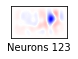

In [150]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
print(tempmax)
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/trainnum_1_RFs_VCNN_channel0_neuron123_activation_max.svg')

In [8]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
data=RF_fl_np[:,0,0]
print(data.shape)

(100, 36, 64)


In [9]:
mask=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        temp=oneSamp_perm_test(data[:,ii,jj], 0, 10000, 66)
        print(temp)
        mask[ii,jj]=temp
#np.save('out_20220423/trainnum_1_activation-max-example-neuron123-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy', mask)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.257
0.8271
0.5916
0.3727
0.0006
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0005
0.0149
0.0066
0.0048
0.0005
0.0
0.0
0.0
0.0002
0.0039
0.0041
0.0002
0.0007
0.0194
0.0665
0.0565
0.0072
0.0002
0.0001
0.0
0.0011
0.021
0.2411
0.6325
0.2674
0.0095
0.0002
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0009
0.1234
0.0
0.0
0.0
0.003
0.7019
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0561
0.0487
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0289
0.1909
0.2669
0.0684
0.0276
0.0074
0.0018
0.0005
0.0029
0.0878
0.6134
0.5356
0.4534
0.7799
0.7095
0.5985
0.734

In [72]:
i=1
mask=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy')

In [73]:
thre=0.01
mask_thre=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        if mask[ii,jj]<thre:
            mask_thre[ii,jj]=0
        else:
            mask_thre[ii,jj]=1  

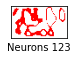

In [74]:
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
tempmax=np.max(np.abs(mask_thre))
axes.imshow(mask_thre,vmin=-1,vmax=1,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/trainnum_1_fig2_RFs_vCNN_gray_channel0_neuron123_perm_test.svg')

In [5]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#mask=np.load('out_20220423/activation-max-example-neuron95-perm_test_mask_seed_35_vcnn_Franke2021.npy')
print (RF_fl_np.shape)
print(mask_thre.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]*mask_thre
tempmax=np.max(np.abs(temp))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/trainnum_1_RFs_VCNN_channel0_neuron123_activation_max_perm_test.svg')

(100, 1, 2, 36, 64)
(1, 2, 36, 64)


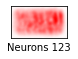

In [87]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/trainnum_1_RFs_with_std_VCNN_std_channel0_neuron123_activation_max.svg')

(1, 2, 36, 64)


Text(0.5, 0, 'Neurons 22')

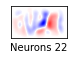

In [78]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 22')
#fig.savefig('out_result_20220423/trainnum_1_RFs_VCNN_channel0_neuron22_activation_max.svg')

In [10]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
data=RF_fl_np[:,0,0]
print(data.shape)

(100, 36, 64)


In [11]:
mask=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        temp=oneSamp_perm_test(data[:,ii,jj], 0, 10000, 66)
        print(temp)
        mask[ii,jj]=temp
#np.save('out_20220423/trainnum_1_activation-max-example-neuron22-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy', mask)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0002
0.0143
0.0033
0.0
0.0
0.0002
0.0007
0.0141
0.0351
0.0354
0.0061
0.0035
0.0006
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0003
0.0003
0.0
0.0
0.0
0.0
0.0001
0.0043
0.0271
0.0695
0.2572
0.3183
0.3632
0.1996
0.4999
0.9235
0.5452
0.1614
0.0778
0.0722
0.219
0.5188
0.6736
0.6467
0.5785
0.3789
0.0697
0.0005
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0002
0.019
0.1237
0.3279
0.1995
0.0539
0.0232
0.0853
0.1699
0.4969
0.4368
0.2724
0.0697
0.0303
0.0113
0.0025
0.0001
0.0
0.0
0.0
0.0
0.0089
0.0643
0.1792
0.0395
0.0046
0.0038
0.002
0.137
0.7979
0.7851
0.2499
0.0744
0.0252
0.0118
0.0034
0.003
0.0055
0.0102
0.0036
0.0008
0.0023
0.0139
0.0286
0.0645
0.0616
0.169
0.2997
0.7619
0.2798
0.0019
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0004
0.1666
0.4362
0.7498
0.7159
0.3805
0.1872
0.3336
0.3909
0.6184
0.8911
0.7838
0.9185
0.4797
0.2361
0.1148
0.0131
0.0039
0.0097
0.0048
0.0459
0.7884
0.401
0.124
0.2408
0.8176
0.6135
0.3152
0.5246
0.4516
0.0248
0.0001
0.0
0.0
0.

In [75]:
i=1
mask=np.load('out_20220423/trainnum_1_activation-max-example-neuron22-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy')

In [76]:
thre=0.01
mask_thre=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        if mask[ii,jj]<thre:
            mask_thre[ii,jj]=0
        else:
            mask_thre[ii,jj]=1

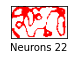

In [77]:
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
tempmax=np.max(np.abs(mask_thre))
axes.imshow(mask_thre,vmin=-1,vmax=1,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 22')
#fig.savefig('out_result_20220423/trainnum_1_fig2_RFs_vCNN_gray_channel0_neuron22_perm_test.svg')

In [ ]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#mask=np.load('out_20220423/activation-max-example-neuron95-perm_test_mask_seed_35_vcnn_Franke2021.npy')
print (RF_fl_np.shape)
print(mask_thre.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]*mask_thre
tempmax=np.max(np.abs(temp))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/trainnum_1_RFs_VCNN_channel0_neuron22_activation_max_perm_test.svg')

(100, 1, 2, 36, 64)
(1, 2, 36, 64)


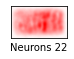

In [86]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 22')
#fig.savefig('out_result_20220423/trainnum_1_RFs_with_std_VCNN_std_channel0_neuron22_activation_max.svg')

(1, 2, 36, 64)


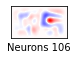

In [79]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron106-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 106')
#fig.savefig('out_result_20220423/trainnum_1_RFs_VCNN_channel0_neuron106_activation_max.svg')

(100, 1, 2, 36, 64)
(1, 2, 36, 64)


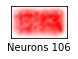

In [85]:
i=1
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron106-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 106')
#fig.savefig('out_result_20220423/trainnum_1_RFs_with_std_VCNN_std_channel0_neuron106_activation_max.svg')

## Variational-sampleFlag=True

In [21]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

i=1
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
torch.manual_seed(i+1)    # reproducible
torch.cuda.manual_seed(i+1)
unit = 95
inputseed = 1
sampleFlag = True
sampleseeds = np.arange(100).tolist()
tempoutputs = []
tempacts = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())
    tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')

    tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
    tempacts.append(tempact)
tempacts = np.copy(tempacts)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
tempoutputs = np.array(tempoutputs)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

outs.shape: (1, 161). Neuron 95 activation: 6.915511131286621
Test activation: outs.shape: (1, 161). Neuron 95 activation: 6.918595314025879
outs.shape: (1, 161). Neuron 95 activation: 7.316039562225342
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.41077995300293
outs.shape: (1, 161). Neuron 95 activation: 6.973232269287109
Test activation: outs.shape: (1, 161). Neuron 95 activation: 8.030560493469238
outs.shape: (1, 161). Neuron 95 activation: 6.434760570526123
Test activation: outs.shape: (1, 161). Neuron 95 activation: 8.26214599609375
outs.shape: (1, 161). Neuron 95 activation: 6.730788230895996
Test activation: outs.shape: (1, 161). Neuron 95 activation: 7.552369594573975
outs.shape: (1, 161). Neuron 95 activation: 7.370116710662842
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.365241050720215
outs.shape: (1, 161). Neuron 95 activation: 8.03625202178955
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.655241012573242
outs.shape: (1, 

In [21]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

i=1
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
torch.manual_seed(i+1)    # reproducible
torch.cuda.manual_seed(i+1)
unit = 95
inputseed = 1
sampleFlag = True
sampleseeds = np.arange(100).tolist()
tempoutputs = []
tempacts = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())
    tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')

    tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
    tempacts.append(tempact)
tempacts = np.copy(tempacts)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
tempoutputs = np.array(tempoutputs)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

outs.shape: (1, 161). Neuron 95 activation: 6.915511131286621
Test activation: outs.shape: (1, 161). Neuron 95 activation: 6.918595314025879
outs.shape: (1, 161). Neuron 95 activation: 7.316039562225342
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.41077995300293
outs.shape: (1, 161). Neuron 95 activation: 6.973232269287109
Test activation: outs.shape: (1, 161). Neuron 95 activation: 8.030560493469238
outs.shape: (1, 161). Neuron 95 activation: 6.434760570526123
Test activation: outs.shape: (1, 161). Neuron 95 activation: 8.26214599609375
outs.shape: (1, 161). Neuron 95 activation: 6.730788230895996
Test activation: outs.shape: (1, 161). Neuron 95 activation: 7.552369594573975
outs.shape: (1, 161). Neuron 95 activation: 7.370116710662842
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.365241050720215
outs.shape: (1, 161). Neuron 95 activation: 8.03625202178955
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.655241012573242
outs.shape: (1, 

In [24]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

i=1
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
torch.manual_seed(i+1)    # reproducible
torch.cuda.manual_seed(i+1)
unit = 123
inputseed = 1
sampleFlag = True
sampleseeds = np.arange(100).tolist()
tempoutputs = []
tempacts = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())
    tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')

    tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
    tempacts.append(tempact)
tempacts = np.copy(tempacts)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
tempoutputs = np.array(tempoutputs)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

outs.shape: (1, 161). Neuron 123 activation: 9.569835662841797
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.842602729797363
outs.shape: (1, 161). Neuron 123 activation: 8.57962703704834
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.470582008361816
outs.shape: (1, 161). Neuron 123 activation: 8.909313201904297
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.479242324829102
outs.shape: (1, 161). Neuron 123 activation: 8.23086929321289
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.24882984161377
outs.shape: (1, 161). Neuron 123 activation: 8.459178924560547
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.323572158813477
outs.shape: (1, 161). Neuron 123 activation: 8.541960716247559
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.111223220825195
outs.shape: (1, 161). Neuron 123 activation: 8.963253021240234
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.911737442016602
ou

In [25]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

i=4
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
torch.manual_seed(i+1)    # reproducible
torch.cuda.manual_seed(i+1)
unit = 123
inputseed = 1
sampleFlag = True
sampleseeds = np.arange(100).tolist()
tempoutputs = []
tempacts = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())
    tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')

    tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
    tempacts.append(tempact)
tempacts = np.copy(tempacts)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
tempoutputs = np.array(tempoutputs)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

outs.shape: (1, 161). Neuron 123 activation: 8.271093368530273
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.41954231262207
outs.shape: (1, 161). Neuron 123 activation: 7.593228816986084
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.125068664550781
outs.shape: (1, 161). Neuron 123 activation: 9.130821228027344
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.927160263061523
outs.shape: (1, 161). Neuron 123 activation: 8.998802185058594
Test activation: outs.shape: (1, 161). Neuron 123 activation: 9.438033103942871
outs.shape: (1, 161). Neuron 123 activation: 9.06215763092041
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.978333473205566
outs.shape: (1, 161). Neuron 123 activation: 8.500598907470703
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.689872741699219
outs.shape: (1, 161). Neuron 123 activation: 8.21104907989502
Test activation: outs.shape: (1, 161). Neuron 123 activation: 8.33773136138916
out

KeyboardInterrupt: 

In [ ]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

i=1
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
torch.manual_seed(i+1)    # reproducible
torch.cuda.manual_seed(i+1)
unit = 22
inputseed = 1
sampleFlag = True
sampleseeds = np.arange(100).tolist()
tempoutputs = []
tempacts = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())
    tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')

    tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
    tempacts.append(tempact)
tempacts = np.copy(tempacts)
np.save('out_20220423/trainnum_1_activation-max-example-neuron22-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
tempoutputs = np.array(tempoutputs)
np.save('out_20220423/trainnum_1_activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

In [ ]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

i=1
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
torch.manual_seed(i+1)    # reproducible
torch.cuda.manual_seed(i+1)
unit = 106
inputseed = 1
sampleFlag = True
sampleseeds = np.arange(100).tolist()
tempoutputs = []
tempacts = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())
    tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')

    tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
    tempacts.append(tempact)
tempacts = np.copy(tempacts)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron106-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
tempoutputs = np.array(tempoutputs)
#np.save('out_20220423/trainnum_1_activation-max-example-neuron106-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

## Fig 2

In [52]:
# neuron95 rcnn
activations_neuron95_rcnn_all=np.zeros([6])
RF_neuron95_rcnn=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron95_rcnn[i]=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
    temp=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-acts_seed_'+str(i)+'_rcnn_Franke2021.npy')
    print(temp.shape)
    activations_neuron95_rcnn_all[i]=temp[0,95]

RF_neuron95_rcnn_mean=np.mean(RF_neuron95_rcnn,axis=0)
print(RF_neuron95_rcnn_mean.shape)
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()
unit=95
temprf= RF_neuron95_rcnn_mean   
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
activations_neuron95_rcnn_all[5]=tempact[0, unit]
print(activations_neuron95_rcnn_all)
#np.save('out_20220423/trainnum_1_all_activations_neuron95_rcnn_Franke2021Data.npy', activations_neuron95_rcnn_all)


# # neuron123 rcnn
# activations_neuron123_rcnn_all=np.zeros([6])
# RF_neuron123_rcnn=np.zeros([5,1,2,36,64])
# for i in range(5):
#     RF_neuron123_rcnn[i]=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
#     temp=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-acts_seed_'+str(i)+'_rcnn_Franke2021.npy')
#     print(temp.shape)
#     activations_neuron123_rcnn_all[i]=temp[0,123]
    
# RF_neuron123_rcnn_mean=np.mean(RF_neuron123_rcnn,axis=0)
# print(RF_neuron123_rcnn_mean.shape)
# testmodel= VanillaCNN()   #with regularization
# testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
# testmodel = testmodel.to(device_cpu) 
# testmodel = testmodel.eval()
# unit=123
# temprf= RF_neuron123_rcnn_mean   
# tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
# activations_neuron123_rcnn_all[5]=tempact[0, unit]
# print(activations_neuron123_rcnn_all)
# #np.save('out_20220423/trainnum_1_all_activations_neuron123_rcnn_Franke2021Data.npy', activations_neuron123_rcnn_all)


(1, 161)
(1, 161)
(1, 161)
(1, 161)
(1, 161)
(1, 2, 36, 64)
[6.31962299 8.13543415 6.5447278  8.5763483  8.37579536 7.70109415]


In [53]:
#neuron 95 vcnn sampleflag=false

activations_neuron95_vcnn_false_all=np.zeros([6])
RF_neuron95_vcnn_false=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron95_vcnn_false[i]=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
    temp=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
    activations_neuron95_vcnn_false_all[i]=temp[0,95]
    
RF_neuron95_vcnn_false_mean=np.mean(RF_neuron95_vcnn_false,axis=0)
print(RF_neuron95_vcnn_false_mean.shape)
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()
unit=95
temprf= RF_neuron95_vcnn_false_mean   
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
activations_neuron95_vcnn_false_all[5]=tempact[0, unit]
print(activations_neuron95_vcnn_false_all)
#np.save('out_20220423/trainnum_1_all_activations_neuron95_vcnn_sampleflag_false_Franke2021Data.npy', activations_neuron95_vcnn_false_all)


# #neuron 123 vcnn sampleflag=false 
    
# activations_neuron123_vcnn_false_all=np.zeros([6])
# RF_neuron123_vcnn_false=np.zeros([5,1,2,36,64])
# for i in range(5):
#     RF_neuron123_vcnn_false[i]=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#     temp=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#     activations_neuron123_vcnn_false_all[i]=temp[0,123]
    
# RF_neuron123_vcnn_false_mean=np.mean(RF_neuron123_vcnn_false,axis=0)
# print(RF_neuron123_vcnn_false_mean.shape)
# testmodel= VanillaCNN()   #with regularization
# testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
# testmodel = testmodel.to(device_cpu) 
# testmodel = testmodel.eval()
# unit=123
# temprf= RF_neuron123_vcnn_false_mean   
# tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
# activations_neuron123_vcnn_false_all[5]=tempact[0, unit]
# print(activations_neuron123_vcnn_false_all)
# #np.save('out_20220423/trainnum_1_all_activations_neuron123_vcnn_sampleflag_false_Franke2021Data.npy', activations_neuron123_vcnn_false_all)
   

(1, 2, 36, 64)
[11.01586437  9.08842373  8.91211605  8.66721344 10.50523663  9.6597662 ]


In [54]:
activations_neuron95_vcnn_true_all=np.zeros([5,100])
RF_neuron95_vcnn_true=np.zeros([5,100,1,2,36,64])
for i in range(5):
    RF_neuron95_vcnn_true[i]=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
    temp=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
    print(temp.shape)
    activations_neuron95_vcnn_true_all[i]=temp[:,0,95]
    print(np.max(activations_neuron95_vcnn_true_all[i]),np.min(activations_neuron95_vcnn_true_all[i]))
#np.save('out_20220423/trainnum_1_all_activations_neuron95_vcnn_sampleflag_true_Franke2021Data.npy', activations_neuron95_vcnn_true_all)


# activations_neuron123_vcnn_true_all=np.zeros([5,100])
# RF_neuron123_vcnn_true=np.zeros([5,100,1,2,36,64])
# for i in range(5):
#     RF_neuron123_vcnn_true[i]=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
#     temp=np.load('out_20220423/trainnum_1_activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
#     print(temp.shape)
#     activations_neuron123_vcnn_true_all[i]=temp[:,0,123]
#     print(np.max(activations_neuron123_vcnn_true_all[i]),np.min(activations_neuron123_vcnn_true_all[i]))
#np.save('out_20220423/trainnum_1_all_activations_neuron123_vcnn_sampleflag_true_Franke2021Data.npy', activations_neuron123_vcnn_true_all)
      

(100, 1, 161)
10.43786334991455 5.17703914642334
(100, 1, 161)
8.944425582885742 4.799567222595215
(100, 1, 161)
8.96959114074707 4.053411960601807
(100, 1, 161)
9.460587501525879 3.4176504611968994
(100, 1, 161)
9.655241012573242 6.653049945831299


In [38]:
activations_neuron95_vcnn=np.zeros([506])
temp=np.load('out_20220423/trainnum_1_all_activations_neuron95_vcnn_sampleflag_true_Franke2021Data.npy')
print(temp.shape)

for i in range(5):
    activations_neuron95_vcnn[i*100:(i+1)*100]=temp[i]
activations_neuron95_vcnn[500:506]=np.load('out_20220423/trainnum_1_all_activations_neuron95_vcnn_sampleflag_false_Franke2021Data.npy')

print(np.max(activations_neuron95_vcnn),np.argmax(activations_neuron95_vcnn))
print(np.min(activations_neuron95_vcnn),np.argmin(activations_neuron95_vcnn))

(5, 100)
11.015864372253418 500
3.4176504611968994 396


In [31]:
print(activations_neuron95_vcnn.shape)

(506,)


In [32]:
print(np.var(activations_neuron95_vcnn,ddof=1))

1.943370162541806


In [80]:
print(activations_neuron95_vcnn_true_all[3,96])

10.529170036315918


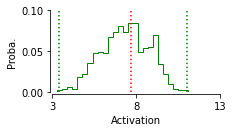

In [82]:
weights = np.ones_like(activations_neuron95_vcnn.flatten())/float(len(activations_neuron95_vcnn.flatten()))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,1.5))
vmin, vmax = 3,12 #np.min(signal_cor_values), np.max(signal_cor_values)
axes.hist(activations_neuron95_vcnn.flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes.axvline(x=7.70109415, color='r', linestyle=':')
axes.axvline(x=3.4176504611968994, color='g', linestyle=':')
axes.axvline(x=11.015864372253418, color='g', linestyle=':')
axes.set_xlim(3, 13)
axes.set_xticks([3,8, 13])
axes.set_yticks([0.0,0.05,0.1])
axes.set_xlabel('Activation')
axes.set_ylabel('Proba.')
#axes.legend(loc='best',frameon=False)
adjust_spines(axes, ['left', 'bottom'])
#fig.savefig('out_result_20220423/trainnum_1_fig2_channel0_neuron95_hist_vcnn_activation_max.svg')

(1, 2, 36, 64)


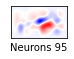

In [62]:
print(RF_neuron95_rcnn_mean.shape)
RF_fl_np=RF_neuron95_rcnn_mean
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/trainnum_1_fig2_RFs_rCNN_channel0_neuron95_activation_max.svg')

(1, 2, 36, 64)


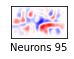

In [63]:
print(RF_neuron95_vcnn_true[3,96].shape)
RF_fl_np=RF_neuron95_vcnn_true[3,96]
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/trainnum_1_fig2_RFs_vCNN_min_channel0_neuron95_activation_max.svg')

(1, 2, 36, 64)


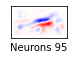

In [65]:
print(RF_neuron95_vcnn_false[0].shape)
RF_fl_np=RF_neuron95_vcnn_false[0]
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/trainnum_1fig2_RFs_vCNN_max_channel0_neuron95_activation_max.svg')

## Fig 3

In [100]:
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_1_Franke2021Data_trainN__seed_1.pth'))

units = np.arange(161).tolist()
inputseeds = np.arange(1,6).tolist()
sampleFlag = False
sampleseed = 1

# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

outputs = [] # numpy array
acts = np.ones(len(units)) * (-np.inf)
for ii,unit in enumerate(units):
    tempoutputs = []
    tempacts = np.ones(len(inputseeds)) * (-np.inf)
    for jj,inputseed in enumerate(inputseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput)
        tempacts[jj] = np.log(tempmodel( tempoutput ).cpu().data.numpy())[0, unit]
    # selected the output image with largest activations based on original tempmodel
    tempbestoutput = tempoutputs[np.argmax(tempacts)] 
    outputs.append(tempbestoutput.cpu().data.numpy())
    
    # test activation
    acts[ii] = np.log(testmodel( tempbestoutput ).cpu().data.numpy())[0, unit] # cancel out the last layer - exp layer
    print(acts[ii])
outputs_rcnn = np.array(outputs)
acts_rcnn = np.copy(acts)
#np.save('out_20220423/trainnum_1_activation-max-all_neurons_seed_'+str(1)+'_rcnn_Franke2021.npy', acts_rcnn)

2.3943655490875244
3.2817931175231934
3.3105170726776123
1.1222343444824219
2.7547857761383057
4.729255199432373
1.77711820602417
3.6825287342071533
3.1019949913024902
1.9470664262771606
2.244337797164917
4.035549640655518
5.547780513763428
2.281815767288208
2.9293417930603027
4.799243927001953
4.393907070159912
4.751321792602539
4.744869232177734
10.423688888549805
3.1042213439941406
10.773964881896973
5.713578701019287
3.3789117336273193
4.183024883270264
6.134993076324463
4.077903747558594
4.65331506729126
5.921212196350098
4.002126693725586
2.088444471359253
3.160426139831543
4.449529647827148
2.1810688972473145
3.945819139480591
5.940375328063965
6.180136680603027
7.778537273406982
3.782460927963257
3.1647679805755615
6.242978572845459
5.485480308532715
4.518154144287109
6.511573791503906
0.9250429272651672
0.7601195573806763
2.174482583999634
3.2504026889801025
6.442813873291016
5.415797710418701
6.814621448516846
0.871965765953064
8.655625343322754
3.322542190551758
9.1440296173

In [101]:
# one model-variation-sampleFlag=False, all neurons, 5 inputseeds
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__seed_1.pth'))

units = np.arange(161).tolist()
inputseeds = np.arange(1,6).tolist()
sampleFlag = False
sampleseed = 1

# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

outputs = [] # numpy array
acts = np.ones(len(units)) * (-np.inf)
for ii,unit in enumerate(units):
    tempoutputs = []
    tempacts = np.ones(len(inputseeds)) * (-np.inf)
    for jj,inputseed in enumerate(inputseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput)
        tempacts[jj] = np.log(tempmodel( tempoutput ).cpu().data.numpy())[0, unit]
    # selected the output image with largest activations based on original tempmodel
    tempbestoutput = tempoutputs[np.argmax(tempacts)] 
    outputs.append(tempbestoutput.cpu().data.numpy())
    
    # test activation
    acts[ii] = np.log(testmodel( tempbestoutput ).cpu().data.numpy())[0, unit] # cancel out the last layer - exp layer
    print(acts[ii])
outputs_vcnn = np.array(outputs)
acts_vcnn = np.copy(acts)
#np.save('out_20220423/trainnum_1_activation-max-all_neurons_seed_'+str(1)+'_vcnn_sampleflag_false_Franke2021.npy', acts_vcnn)

3.084470748901367
3.954329252243042
3.960022211074829
3.170764207839966
2.958080768585205
4.463377952575684
2.612095594406128
3.9478607177734375
3.541410207748413
2.5013952255249023
3.662952184677124
3.5605504512786865
5.404238224029541
2.8244829177856445
3.498643636703491
5.5166335105896
5.992545127868652
5.528007507324219
5.960028648376465
11.038250923156738
4.209772109985352
11.729084014892578
5.78251838684082
4.031474590301514
4.8952436447143555
6.530657768249512
4.226252555847168
5.0793962478637695
6.823529243469238
4.5474090576171875
2.6445443630218506
4.8386006355285645
4.46558141708374
2.54799222946167
5.1634979248046875
5.817378520965576
6.505001068115234
11.165257453918457
4.41465950012207
3.736694574356079
8.172185897827148
6.128818035125732
4.191583156585693
6.871840476989746
1.0932499170303345
2.731163501739502
3.0187857151031494
2.811089515686035
7.38957405090332
7.408924102783203
6.286242485046387
1.5489065647125244
9.335233688354492
4.0559587478637695
8.848830223083496


In [127]:
activations_rcnn=np.load('out_20220423/trainnum_1_activation-max-all_neurons_seed_'+str(1)+'_rcnn_Franke2021.npy')
activations_vcnn_false=np.load('out_20220423/trainnum_1_activation-max-all_neurons_seed_'+str(1)+'_vcnn_sampleflag_false_Franke2021.npy')
print(activations_rcnn.shape)

(161,)


No handles with labels found to put in legend.


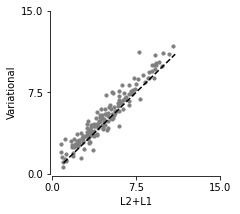

In [128]:
# compare
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.scatter(activations_rcnn.flatten(), activations_vcnn_false.flatten(),s=10,c='gray')
ax.plot([1,11], [1,11],ls='--', c='k')
ax.set_xlabel('L2+L1')
ax.set_ylabel('Variational')
ax.set_xticks([0, 7.5, 15])
ax.set_yticks([0, 7.5, 15])

ax.legend(loc='best',frameon=False)
handles, labels = ax.get_legend_handles_labels()
adjust_spines(ax, ['left', 'bottom'])
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/scatter_activation_max_seed1_trainnum1.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [117]:
temp=np.zeros(161)
for ii in range(161):
    temp[ii]=activations_vcnn_false[ii]-activations_rcnn[ii]
len([i for i  in temp if i >0])

128

# example unit

## Vanilla

In [5]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 95
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_rcnn_Franke2021.npy', out_rcnn)

outs.shape: (1, 161). Neuron 95 activation: 5.514772891998291
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.366104125976562
outs.shape: (1, 161). Neuron 95 activation: 10.779956817626953
Test activation: outs.shape: (1, 161). Neuron 95 activation: 11.334051132202148
outs.shape: (1, 161). Neuron 95 activation: 7.798956394195557
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.134786605834961
outs.shape: (1, 161). Neuron 95 activation: 6.540046691894531
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.338242530822754
outs.shape: (1, 161). Neuron 95 activation: 15.290060997009277
Test activation: outs.shape: (1, 161). Neuron 95 activation: 11.0559663772583


In [6]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 123
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_rcnn_Franke2021.npy', out_rcnn)

outs.shape: (1, 161). Neuron 123 activation: 9.516731262207031
Test activation: outs.shape: (1, 161). Neuron 123 activation: 10.696473121643066
outs.shape: (1, 161). Neuron 123 activation: 11.715110778808594
Test activation: outs.shape: (1, 161). Neuron 123 activation: 11.32033920288086
outs.shape: (1, 161). Neuron 123 activation: 9.952503204345703
Test activation: outs.shape: (1, 161). Neuron 123 activation: 11.18883228302002
outs.shape: (1, 161). Neuron 123 activation: 9.473052978515625
Test activation: outs.shape: (1, 161). Neuron 123 activation: 11.055442810058594
outs.shape: (1, 161). Neuron 123 activation: 16.504180908203125
Test activation: outs.shape: (1, 161). Neuron 123 activation: 11.73458194732666


In [50]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 22
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20220423/activation-max-example-neuron22-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20220423/activation-max-example-neuron22-acts_seed_'+str(i)+'_rcnn_Franke2021.npy', out_rcnn)

outs.shape: (1, 161). Neuron 22 activation: 7.7093186378479
Test activation: outs.shape: (1, 161). Neuron 22 activation: 8.55702018737793
outs.shape: (1, 161). Neuron 22 activation: 9.086657524108887
Test activation: outs.shape: (1, 161). Neuron 22 activation: 8.922502517700195
outs.shape: (1, 161). Neuron 22 activation: 7.390469074249268
Test activation: outs.shape: (1, 161). Neuron 22 activation: 9.077264785766602
outs.shape: (1, 161). Neuron 22 activation: 7.350115776062012
Test activation: outs.shape: (1, 161). Neuron 22 activation: 9.068389892578125
outs.shape: (1, 161). Neuron 22 activation: 11.733522415161133
Test activation: outs.shape: (1, 161). Neuron 22 activation: 9.29658317565918


In [51]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 106
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20220423/activation-max-example-neuron106-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20220423/activation-max-example-neuron106-acts_seed_'+str(i)+'_rcnn_Franke2021.npy', out_rcnn)

outs.shape: (1, 161). Neuron 106 activation: 7.9014506340026855
Test activation: outs.shape: (1, 161). Neuron 106 activation: 10.349552154541016
outs.shape: (1, 161). Neuron 106 activation: 10.947273254394531
Test activation: outs.shape: (1, 161). Neuron 106 activation: 11.633806228637695
outs.shape: (1, 161). Neuron 106 activation: 10.022603988647461
Test activation: outs.shape: (1, 161). Neuron 106 activation: 10.972943305969238
outs.shape: (1, 161). Neuron 106 activation: 8.459760665893555
Test activation: outs.shape: (1, 161). Neuron 106 activation: 10.947324752807617
outs.shape: (1, 161). Neuron 106 activation: 17.392436981201172
Test activation: outs.shape: (1, 161). Neuron 106 activation: 12.105481147766113


(1, 2, 36, 64)


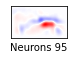

In [22]:
i=3
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/RFs_with_std_rCNN_channel0_neuron95_activation_max.svg')

(1, 2, 36, 64)


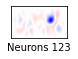

In [44]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/RFs_with_std_rCNN_channel0_neuron123_activation_max.svg')

(1, 2, 36, 64)


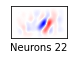

In [52]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron22-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 22')
#fig.savefig('out_result_20220423/RFs_with_std_rCNN_channel0_neuron22_activation_max.svg')

(1, 2, 36, 64)


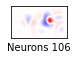

In [53]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron106-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 106')
#fig.savefig('out_result_20220423/RFs_with_std_rCNN_channel0_neuron106_activation_max.svg')

## variation-sampleFlag=False

In [7]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 95
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', out_vcnn)

outs.shape: (1, 161). Neuron 95 activation: 8.139802932739258
Test activation: outs.shape: (1, 161). Neuron 95 activation: 11.464073181152344
outs.shape: (1, 161). Neuron 95 activation: 14.924683570861816
Test activation: outs.shape: (1, 161). Neuron 95 activation: 12.466804504394531
outs.shape: (1, 161). Neuron 95 activation: 20.804401397705078
Test activation: outs.shape: (1, 161). Neuron 95 activation: 11.852477073669434
outs.shape: (1, 161). Neuron 95 activation: 17.33961296081543
Test activation: outs.shape: (1, 161). Neuron 95 activation: 12.350081443786621
outs.shape: (1, 161). Neuron 95 activation: 18.05668067932129
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.477787971496582


In [8]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 123
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', out_vcnn)

outs.shape: (1, 161). Neuron 123 activation: 8.795340538024902
Test activation: outs.shape: (1, 161). Neuron 123 activation: 10.626594543457031
outs.shape: (1, 161). Neuron 123 activation: 14.711453437805176
Test activation: outs.shape: (1, 161). Neuron 123 activation: 11.530695915222168
outs.shape: (1, 161). Neuron 123 activation: 23.199644088745117
Test activation: outs.shape: (1, 161). Neuron 123 activation: 11.010093688964844
outs.shape: (1, 161). Neuron 123 activation: 21.88384246826172
Test activation: outs.shape: (1, 161). Neuron 123 activation: 11.201179504394531
outs.shape: (1, 161). Neuron 123 activation: 19.887861251831055
Test activation: outs.shape: (1, 161). Neuron 123 activation: 10.534440040588379


In [54]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 22
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20220423/activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20220423/activation-max-example-neuron22-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', out_vcnn)

outs.shape: (1, 161). Neuron 22 activation: 7.028380393981934
Test activation: outs.shape: (1, 161). Neuron 22 activation: 8.79511833190918
outs.shape: (1, 161). Neuron 22 activation: 10.429603576660156
Test activation: outs.shape: (1, 161). Neuron 22 activation: 9.023853302001953
outs.shape: (1, 161). Neuron 22 activation: 13.72353458404541
Test activation: outs.shape: (1, 161). Neuron 22 activation: 8.171622276306152
outs.shape: (1, 161). Neuron 22 activation: 14.32649040222168
Test activation: outs.shape: (1, 161). Neuron 22 activation: 7.5069661140441895
outs.shape: (1, 161). Neuron 22 activation: 14.490431785583496
Test activation: outs.shape: (1, 161). Neuron 22 activation: 7.769730567932129


In [55]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 106
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20220423/activation-max-example-neuron106-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20220423/activation-max-example-neuron106-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', out_vcnn)

outs.shape: (1, 161). Neuron 106 activation: 6.586557388305664
Test activation: outs.shape: (1, 161). Neuron 106 activation: 10.536808013916016
outs.shape: (1, 161). Neuron 106 activation: 14.653847694396973
Test activation: outs.shape: (1, 161). Neuron 106 activation: 12.636109352111816
outs.shape: (1, 161). Neuron 106 activation: 26.615488052368164
Test activation: outs.shape: (1, 161). Neuron 106 activation: 12.051142692565918
outs.shape: (1, 161). Neuron 106 activation: 23.149349212646484
Test activation: outs.shape: (1, 161). Neuron 106 activation: 12.170916557312012
outs.shape: (1, 161). Neuron 106 activation: 25.093814849853516
Test activation: outs.shape: (1, 161). Neuron 106 activation: 11.794869422912598


(1, 2, 36, 64)


Text(0.5, 0, 'Neurons 95')

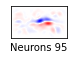

In [6]:
i=3
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/RFs_VCNN_channel0_neuron95_activation_max.svg')

In [14]:
i=3
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
data=RF_fl_np[:,0,0]
print(data.shape)

(100, 36, 64)


In [ ]:
mask=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        temp=oneSamp_perm_test(data[:,ii,jj], 0, 10000, 66)
        print(temp)
        mask[ii,jj]=temp
#np.save('out_20220423/activation-max-example-neuron95-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy', mask)

In [19]:
i=3
mask = np.load('out_20220423/activation-max-example-neuron95-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy')

In [20]:
thre=0.05
mask_thre=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        if mask[ii,jj]<thre:
            mask_thre[ii,jj]=0
        else:
            mask_thre[ii,jj]=1    

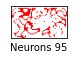

In [22]:
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
tempmax=np.max(np.abs(mask_thre))
axes.imshow(mask_thre,vmin=-1,vmax=1,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/fig2_RFs_vCNN_gray_channel0_neuron95_perm_test.svg')

(1, 2, 36, 64)
(36, 64)


Text(0.5, 0, 'Neurons 95')

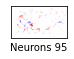

In [23]:
i=3
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#mask=np.load('out_20220423/activation-max-example-neuron95-perm_test_mask_seed_35_vcnn_Franke2021.npy')
print (RF_fl_np.shape)
print(mask_thre.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]*mask_thre
tempmax=np.max(np.abs(temp))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/RFs_VCNN_channel0_neuron95_activation_max_perm_test.svg')

(100, 1, 2, 36, 64)
(1, 2, 36, 64)


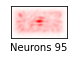

In [21]:
i=3
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/RFs_with_std_VCNN_std_channel0_neuron95_activation_max.svg')

(1, 2, 36, 64)
2.297056


Text(0.5, 0, 'Neurons 123')

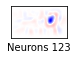

In [170]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
print(tempmax)
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/RFs_VCNN_channel0_neuron123_activation_max.svg')

In [12]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
data=RF_fl_np[:,0,0]
print(data.shape)

(100, 36, 64)


In [ ]:
mask=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        temp=oneSamp_perm_test(data[:,ii,jj], 0, 10000, 66)
        print(temp)
        mask[ii,jj]=temp
#np.save('out_20220423/activation-max-example-neuron123-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy', mask)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0274
0.4048
0.8821
0.6351
0.0318
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0001
0.0001
0.0001
0.0
0.0
0.0
0.0002
0.0003
0.0042
0.1277
0.3317
0.6781
0.5443
0.0185
0.0001
0.0
0.0
0.0
0.0
0.0
0.0019
0.3519
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.014
0.1564
0.0479
0.0007
0.0
0.0
0.0
0.0003
0.1957
0.6926
0.353
0.8392
0.1284
0.004
0.0013
0.0086
0.0727
0.1397
0.113

In [24]:
i=1
mask = np.load('out_20220423/activation-max-example-neuron123-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy')

In [26]:
thre=0.05
mask_thre=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        if mask[ii,jj]<thre:
            mask_thre[ii,jj]=0
        else:
            mask_thre[ii,jj]=1       

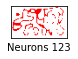

In [29]:
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
tempmax=np.max(np.abs(mask_thre))
axes.imshow(mask_thre,vmin=-1,vmax=1,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/fig2_RFs_vCNN_gray_channel0_neuron123_perm_test.svg')

In [ ]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#mask=np.load('out_20220423/activation-max-example-neuron95-perm_test_mask_seed_35_vcnn_Franke2021.npy')
print (RF_fl_np.shape)
print(mask_thre.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]*mask_thre
tempmax=np.max(np.abs(temp))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/RFs_VCNN_channel0_neuron123_activation_max_perm_test.svg')

(100, 1, 2, 36, 64)
(1, 2, 36, 64)


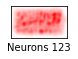

In [49]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/RFs_with_std_VCNN_std_channel0_neuron123_activation_max.svg')

(1, 2, 36, 64)


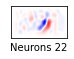

In [56]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 22')
#fig.savefig('out_result_20220423/RFs_VCNN_channel0_neuron22_activation_max.svg')

In [ ]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
data=RF_fl_np[:,0,0]
print(data.shape)

In [ ]:
mask=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        temp=oneSamp_perm_test(data[:,ii,jj], 0, 10000, 66)
        print(temp)
        mask[ii,jj]=temp
#np.save('out_20220423/activation-max-example-neuron22-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy', mask)

In [30]:
i=1
mask = np.load('out_20220423/activation-max-example-neuron22-perm_test_mask_seed_'+str(i)+'_vcnn_Franke2021.npy')

In [31]:
thre=0.05
mask_thre=np.zeros([data.shape[1],data.shape[2]])
for ii in range(data.shape[1]):
    for jj in range(data.shape[2]):
        if mask[ii,jj]<thre:
            mask_thre[ii,jj]=0
        else:
            mask_thre[ii,jj]=1  

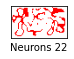

In [32]:
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
tempmax=np.max(np.abs(mask_thre))
axes.imshow(mask_thre,vmin=-1,vmax=1,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 22')
#fig.savefig('out_result_20220423/fig2_RFs_vCNN_gray_channel0_neuron22_perm_test.svg')

In [ ]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#mask=np.load('out_20220423/activation-max-example-neuron95-perm_test_mask_seed_35_vcnn_Franke2021.npy')
print (RF_fl_np.shape)
print(mask_thre.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]*mask_thre
tempmax=np.max(np.abs(temp))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 123')
#fig.savefig('out_result_20220423/RFs_VCNN_channel0_neuron22_activation_max_perm_test.svg')

(100, 1, 2, 36, 64)
(1, 2, 36, 64)


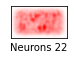

In [60]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 22')
#fig.savefig('out_result_20220423/RFs_with_std_VCNN_std_channel0_neuron22_activation_max.svg')

(1, 2, 36, 64)


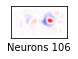

In [58]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron106-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 106')
#fig.savefig('out_result_20220423/RFs_VCNN_channel0_neuron106_activation_max.svg')

(100, 1, 2, 36, 64)
(1, 2, 36, 64)


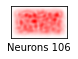

In [61]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron106-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 106')
#fig.savefig('out_result_20220423/RFs_with_std_VCNN_std_channel0_neuron106_activation_max.svg')

## Variational-sampleFlag=True

In [ ]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 95
    inputseed = 1
    sampleFlag = True
    sampleseeds = np.arange(100).tolist()
    tempoutputs = []
    tempacts = []
    for ii, sampleseed in enumerate(sampleseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput.cpu().data.numpy())
        tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        
        tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        tempacts.append(tempact)
    tempacts = np.copy(tempacts)
    #np.save('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
    tempoutputs = np.array(tempoutputs)
    #np.save('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

outs.shape: (1, 161). Neuron 95 activation: 7.207523345947266
Test activation: outs.shape: (1, 161). Neuron 95 activation: 10.56196403503418
outs.shape: (1, 161). Neuron 95 activation: 6.957485198974609
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.692117691040039
outs.shape: (1, 161). Neuron 95 activation: 7.656599998474121
Test activation: outs.shape: (1, 161). Neuron 95 activation: 10.825297355651855
outs.shape: (1, 161). Neuron 95 activation: 7.419320583343506
Test activation: outs.shape: (1, 161). Neuron 95 activation: 10.548727989196777
outs.shape: (1, 161). Neuron 95 activation: 7.001949787139893
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.976970672607422
outs.shape: (1, 161). Neuron 95 activation: 7.14988374710083
Test activation: outs.shape: (1, 161). Neuron 95 activation: 10.483778953552246
outs.shape: (1, 161). Neuron 95 activation: 7.398540496826172
Test activation: outs.shape: (1, 161). Neuron 95 activation: 10.627120971679688
outs.shape

In [ ]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 123
    inputseed = 1
    sampleFlag = True
    sampleseeds = np.arange(100).tolist()
    tempoutputs = []
    tempacts = []
    for ii, sampleseed in enumerate(sampleseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput.cpu().data.numpy())
        tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        
        tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        tempacts.append(tempact)
    tempacts = np.copy(tempacts)
    #np.save('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
    tempoutputs = np.array(tempoutputs)
    #np.save('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

In [12]:
print(tempoutputs.shape)

(100, 1, 2, 36, 64)


In [36]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 106
    inputseed = 1
    sampleFlag = True
    sampleseeds = np.arange(100).tolist()
    tempoutputs = []
    tempacts = []
    for ii, sampleseed in enumerate(sampleseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput.cpu().data.numpy())
        tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        
        tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        tempacts.append(tempact)
    tempacts = np.copy(tempacts)
    #np.save('out_20220423/activation-max-example-neuron106-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
    tempoutputs = np.array(tempoutputs)
    #np.save('out_20220423/activation-max-example-neuron106-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

outs.shape: (1, 161). Neuron 106 activation: 5.525534152984619
Test activation: outs.shape: (1, 161). Neuron 106 activation: 8.34249210357666
outs.shape: (1, 161). Neuron 106 activation: 5.390837669372559
Test activation: outs.shape: (1, 161). Neuron 106 activation: 9.009254455566406
outs.shape: (1, 161). Neuron 106 activation: 4.942808151245117
Test activation: outs.shape: (1, 161). Neuron 106 activation: 7.84451150894165
outs.shape: (1, 161). Neuron 106 activation: 5.786282539367676
Test activation: outs.shape: (1, 161). Neuron 106 activation: 9.532681465148926
outs.shape: (1, 161). Neuron 106 activation: 5.248964309692383
Test activation: outs.shape: (1, 161). Neuron 106 activation: 7.530672073364258
outs.shape: (1, 161). Neuron 106 activation: 5.495682239532471
Test activation: outs.shape: (1, 161). Neuron 106 activation: 9.115301132202148
outs.shape: (1, 161). Neuron 106 activation: 5.233972072601318
Test activation: outs.shape: (1, 161). Neuron 106 activation: 8.264191627502441
o

In [37]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 22
    inputseed = 1
    sampleFlag = True
    sampleseeds = np.arange(100).tolist()
    tempoutputs = []
    tempacts = []
    for ii, sampleseed in enumerate(sampleseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput.cpu().data.numpy())
        tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        
        tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        tempacts.append(tempact)
    tempacts = np.copy(tempacts)
    #np.save('out_20220423/activation-max-example-neuron22-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
    tempoutputs = np.array(tempoutputs)
    #np.save('out_20220423/activation-max-example-neuron22-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

outs.shape: (1, 161). Neuron 22 activation: 6.039906024932861
Test activation: outs.shape: (1, 161). Neuron 22 activation: 7.618145942687988
outs.shape: (1, 161). Neuron 22 activation: 6.011272430419922
Test activation: outs.shape: (1, 161). Neuron 22 activation: 8.024084091186523
outs.shape: (1, 161). Neuron 22 activation: 6.290956974029541
Test activation: outs.shape: (1, 161). Neuron 22 activation: 8.050520896911621
outs.shape: (1, 161). Neuron 22 activation: 5.8265485763549805
Test activation: outs.shape: (1, 161). Neuron 22 activation: 7.582606315612793
outs.shape: (1, 161). Neuron 22 activation: 6.3505120277404785
Test activation: outs.shape: (1, 161). Neuron 22 activation: 7.977468967437744
outs.shape: (1, 161). Neuron 22 activation: 5.892694473266602
Test activation: outs.shape: (1, 161). Neuron 22 activation: 7.8519721031188965
outs.shape: (1, 161). Neuron 22 activation: 5.912110805511475
Test activation: outs.shape: (1, 161). Neuron 22 activation: 7.810054302215576
outs.shape

In [ ]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()
units=np.arange(150,161)

for j in range(11):
    for i in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
        torch.manual_seed(seeds[i])    # reproducible
        torch.cuda.manual_seed(seeds[i])
        unit = units[j]
        inputseed = 1
        sampleFlag = True
        sampleseeds = np.arange(100).tolist()
        tempoutputs = []
        tempacts = []
        for ii, sampleseed in enumerate(sampleseeds):
            tempoutput = act_max_pack(
                tempmodel = tempmodel, # model
                train_std = train_std, # torch.tensor, from the training data
                unit = unit,             # neuron id
                inputseed = inputseed,   # for input_img
                sampleFlag = sampleFlag,      # for variational model
                sampleseed = sampleseed,      # for variational model
            )
            tempoutputs.append(tempoutput.cpu().data.numpy())
            tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
            print (f'outs.shape: {tempact.shape}. Neuron {unit} activation: {tempact[0, unit]}')

            tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
            print (f'Test activation: outs.shape: {tempact.shape}. Neuron {unit} activation: {tempact[0, unit]}')
            tempacts.append(tempact)
        tempacts = np.copy(tempacts)
        #np.save('out_20220423/activation-max-example-neuron'+str(unit)+'-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempacts)
        tempoutputs = np.array(tempoutputs)
        #np.save('out_20220423/activation-max-example-neuron'+str(unit)+'-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy', tempoutputs)

outs.shape: (1, 161). Neuron 150 activation: 2.3279781341552734
Test activation: outs.shape: (1, 161). Neuron 150 activation: 5.090145111083984
outs.shape: (1, 161). Neuron 150 activation: 1.90615713596344
Test activation: outs.shape: (1, 161). Neuron 150 activation: 4.456123352050781
outs.shape: (1, 161). Neuron 150 activation: 2.519134998321533
Test activation: outs.shape: (1, 161). Neuron 150 activation: 5.0547661781311035
outs.shape: (1, 161). Neuron 150 activation: 2.581303596496582
Test activation: outs.shape: (1, 161). Neuron 150 activation: 4.308109283447266
outs.shape: (1, 161). Neuron 150 activation: 2.2276928424835205
Test activation: outs.shape: (1, 161). Neuron 150 activation: 4.609192371368408
outs.shape: (1, 161). Neuron 150 activation: 1.6471527814865112
Test activation: outs.shape: (1, 161). Neuron 150 activation: 3.2521910667419434
outs.shape: (1, 161). Neuron 150 activation: 2.2790207862854004
Test activation: outs.shape: (1, 161). Neuron 150 activation: 5.0048089027

## Fig 2

In [6]:
# neuron95 rcnn
activations_neuron95_rcnn_all=np.zeros([6])
RF_neuron95_rcnn=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron95_rcnn[i]=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
    temp=np.load('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_rcnn_Franke2021.npy')
    print(temp.shape)
    activations_neuron95_rcnn_all[i]=temp[0,95]

RF_neuron95_rcnn_mean=np.mean(RF_neuron95_rcnn,axis=0)
print(RF_neuron95_rcnn_mean.shape)
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()
unit=95
temprf= RF_neuron95_rcnn_mean   
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
activations_neuron95_rcnn_all[5]=tempact[0, unit]
print(activations_neuron95_rcnn_all)
#np.save('out_20220423/all_activations_neuron95_rcnn_Franke2021Data.npy', activations_neuron95_rcnn_all)


# # neuron123 rcnn
# activations_neuron123_rcnn_all=np.zeros([6])
# RF_neuron123_rcnn=np.zeros([5,1,2,36,64])
# for i in range(5):
#     RF_neuron123_rcnn[i]=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
#     temp=np.load('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_rcnn_Franke2021.npy')
#     print(temp.shape)
#     activations_neuron123_rcnn_all[i]=temp[0,123]
    
# RF_neuron123_rcnn_mean=np.mean(RF_neuron123_rcnn,axis=0)
# print(RF_neuron123_rcnn_mean.shape)
# testmodel= VanillaCNN()   #with regularization
# testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
# testmodel = testmodel.to(device_cpu) 
# testmodel = testmodel.eval()
# unit=123
# temprf= RF_neuron123_rcnn_mean   
# tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
# activations_neuron123_rcnn_all[5]=tempact[0, unit]
# print(activations_neuron123_rcnn_all)
# #np.save('out_20220423/all_activations_neuron123_rcnn_Franke2021Data.npy', activations_neuron123_rcnn_all)


(1, 161)
(1, 161)
(1, 161)
(1, 161)
(1, 161)
(1, 2, 36, 64)
[ 9.36610413 11.33405113  9.13478661  9.33824253 11.05596638 10.12978363]


In [7]:
#neuron 95 vcnn sampleflag=false

activations_neuron95_vcnn_false_all=np.zeros([6])
RF_neuron95_vcnn_false=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron95_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
    temp=np.load('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
    activations_neuron95_vcnn_false_all[i]=temp[0,95]
    
RF_neuron95_vcnn_false_mean=np.mean(RF_neuron95_vcnn_false,axis=0)
print(RF_neuron95_vcnn_false_mean.shape)
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()
unit=95
temprf= RF_neuron95_vcnn_false_mean   
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
activations_neuron95_vcnn_false_all[5]=tempact[0, unit]
print(activations_neuron95_vcnn_false_all)
#np.save('out_20220423/all_activations_neuron95_vcnn_sampleflag_false_Franke2021Data.npy', activations_neuron95_vcnn_false_all)


# #neuron 123 vcnn sampleflag=false 
    
# activations_neuron123_vcnn_false_all=np.zeros([6])
# RF_neuron123_vcnn_false=np.zeros([5,1,2,36,64])
# for i in range(5):
#     RF_neuron123_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#     temp=np.load('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
#     activations_neuron123_vcnn_false_all[i]=temp[0,123]
    
# RF_neuron123_vcnn_false_mean=np.mean(RF_neuron123_vcnn_false,axis=0)
# print(RF_neuron123_vcnn_false_mean.shape)
# testmodel= VanillaCNN()   #with regularization
# testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
# testmodel = testmodel.to(device_cpu) 
# testmodel = testmodel.eval()
# unit=123
# temprf= RF_neuron123_vcnn_false_mean   
# tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
# activations_neuron123_vcnn_false_all[5]=tempact[0, unit]
# print(activations_neuron123_vcnn_false_all)
# #np.save('out_20220423/all_activations_neuron123_vcnn_sampleflag_false_Franke2021Data.npy', activations_neuron123_vcnn_false_all)
   

(1, 2, 36, 64)
[11.46407318 12.4668045  11.85247707 12.35008144  9.47778797 11.55065632]


In [8]:
activations_neuron95_vcnn_true_all=np.zeros([5,100])
RF_neuron95_vcnn_true=np.zeros([5,100,1,2,36,64])
for i in range(5):
    RF_neuron95_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
    temp=np.load('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
    print(temp.shape)
    activations_neuron95_vcnn_true_all[i]=temp[:,0,95]
    print(np.max(activations_neuron95_vcnn_true_all[i]),np.min(activations_neuron95_vcnn_true_all[i]))
#np.save('out_20220423/all_activations_neuron95_vcnn_sampleflag_true_Franke2021Data.npy', activations_neuron95_vcnn_true_all)


# activations_neuron123_vcnn_true_all=np.zeros([5,100])
# RF_neuron123_vcnn_true=np.zeros([5,100,1,2,36,64])
# for i in range(5):
#     RF_neuron123_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
#     temp=np.load('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
#     print(temp.shape)
#     activations_neuron123_vcnn_true_all[i]=temp[:,0,123]
#     print(np.max(activations_neuron123_vcnn_true_all[i]),np.min(activations_neuron123_vcnn_true_all[i]))
# #np.save('out_20220423/all_activations_neuron123_vcnn_sampleflag_true_Franke2021Data.npy', activations_neuron123_vcnn_true_all)
      

(100, 1, 161)
11.14703369140625 9.09762954711914
(100, 1, 161)
11.968070983886719 9.093023300170898
(100, 1, 161)
11.01191234588623 7.80025053024292
(100, 1, 161)
11.588175773620605 7.013171672821045
(100, 1, 161)
11.41462230682373 1.1111886501312256


In [40]:
activations_neuron95_vcnn=np.zeros([506])
temp=np.load('out_20220423/all_activations_neuron95_vcnn_sampleflag_true_Franke2021Data.npy')
print(temp.shape)

for i in range(5):
    activations_neuron95_vcnn[i*100:(i+1)*100]=temp[i]
activations_neuron95_vcnn[500:506]=np.load('out_20220423/all_activations_neuron95_vcnn_sampleflag_false_Franke2021Data.npy')

print(np.max(activations_neuron95_vcnn),np.argmax(activations_neuron95_vcnn))
print(np.min(activations_neuron95_vcnn),np.argmin(activations_neuron95_vcnn))

(5, 100)
12.466804504394531 501
1.1111886501312256 471


In [43]:
print(np.var(activations_neuron95_vcnn,ddof=1))

1.5910290072065414


In [36]:
print(np.sort(activations_neuron95_vcnn)[0:10])

[1.11118865 4.10511684 5.48542166 6.8323307  7.01317167 7.04231882
 7.09689236 7.13410378 7.17920923 7.18359518]


In [10]:
print(np.min(activations_neuron95_vcnn[300:400]),np.argmin(activations_neuron95_vcnn[300:400]))
print(activations_neuron95_vcnn_true_all[3,49])

7.013171672821045 49
7.013171672821045


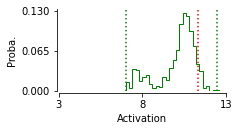

In [11]:
weights = np.ones_like(activations_neuron95_vcnn.flatten())/float(len(activations_neuron95_vcnn.flatten()))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,1.5))
vmin, vmax = 7,13 #np.min(signal_cor_values), np.max(signal_cor_values)
axes.hist(activations_neuron95_vcnn.flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes.axvline(x=11.33405113, color='r', linestyle=':')
axes.axvline(x=7.013171672821045, color='g', linestyle=':')
axes.axvline(x=12.4668045043945313, color='g', linestyle=':')
axes.set_xlim(3, 13)
axes.set_xticks([3,8, 13])
axes.set_yticks([0.0,0.065,0.13])
axes.set_xlabel('Activation')
axes.set_ylabel('Proba.')
#axes.legend(loc='best',frameon=False)
adjust_spines(axes, ['left', 'bottom'])
#fig.savefig('out_result_20220423/fig2_channel0_neuron95_hist_vcnn_activation_max.svg')

(1, 2, 36, 64)


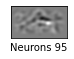

In [13]:
print(RF_neuron95_vcnn_true[3,49].shape)
RF_fl_np=RF_neuron95_vcnn_true[3,49]
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='gray')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/fig2_RFs_vCNN_min_gray_channel0_neuron95_activation_max.svg')

(1, 2, 36, 64)


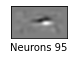

In [14]:
print(RF_neuron95_vcnn_false[1].shape)
RF_fl_np=RF_neuron95_vcnn_false[1]
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,1))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='gray')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 95')
#fig.savefig('out_result_20220423/fig2_RFs_vCNN_max_gray_channel0_neuron95_activation_max.svg')

## Fig 3

In [98]:
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_1.pth'))

units = np.arange(161).tolist()
inputseeds = np.arange(1,6).tolist()
sampleFlag = False
sampleseed = 1

# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

outputs = [] # numpy array
acts = np.ones(len(units)) * (-np.inf)
for ii,unit in enumerate(units):
    tempoutputs = []
    tempacts = np.ones(len(inputseeds)) * (-np.inf)
    for jj,inputseed in enumerate(inputseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput)
        tempacts[jj] = np.log(tempmodel( tempoutput ).cpu().data.numpy())[0, unit]
    # selected the output image with largest activations based on original tempmodel
    tempbestoutput = tempoutputs[np.argmax(tempacts)] 
    outputs.append(tempbestoutput.cpu().data.numpy())
    
    # test activation
    acts[ii] = np.log(testmodel( tempbestoutput ).cpu().data.numpy())[0, unit] # cancel out the last layer - exp layer
    print(acts[ii])
outputs_rcnn = np.array(outputs)
acts_rcnn = np.copy(acts)
#np.save('out_20220423/activation-max-all_neurons_seed_'+str(1)+'_rcnn_Franke2021.npy', acts_rcnn)

3.8082892894744873
6.600779056549072
7.119945049285889
6.244288444519043
5.800964832305908
8.414623260498047
4.081233501434326
7.751373767852783
6.137097358703613
3.7453224658966064
6.641958713531494
5.791835308074951
8.41818618774414
4.545143127441406
5.111268997192383
7.133783340454102
8.59687328338623
9.155457496643066
7.568574905395508
15.023770332336426
6.401888370513916
15.007452011108398
8.922502517700195
8.228217124938965
5.6232590675354
8.376755714416504
5.380131244659424
6.344888210296631
8.10581111907959
5.963980197906494
3.9133481979370117
6.614201545715332
6.963774681091309
4.448849678039551
6.248871326446533
9.796541213989258
8.906781196594238
13.538202285766602
6.8025126457214355
7.47191858291626
9.806899070739746
8.195610046386719
7.430736064910889
9.552570343017578
2.5888020992279053
4.446274280548096
4.445608139038086
4.241308689117432
9.21394157409668
8.30530834197998
8.937432289123535
4.066202640533447
12.766643524169922
8.254384994506836
11.072742462158203
11.30010

In [99]:
# one model-variation-sampleFlag=False, all neurons, 5 inputseeds
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_1.pth'))

units = np.arange(161).tolist()
inputseeds = np.arange(1,6).tolist()
sampleFlag = False
sampleseed = 1

# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

outputs = [] # numpy array
acts = np.ones(len(units)) * (-np.inf)
for ii,unit in enumerate(units):
    tempoutputs = []
    tempacts = np.ones(len(inputseeds)) * (-np.inf)
    for jj,inputseed in enumerate(inputseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput)
        tempacts[jj] = np.log(tempmodel( tempoutput ).cpu().data.numpy())[0, unit]
    # selected the output image with largest activations based on original tempmodel
    tempbestoutput = tempoutputs[np.argmax(tempacts)] 
    outputs.append(tempbestoutput.cpu().data.numpy())
    
    # test activation
    acts[ii] = np.log(testmodel( tempbestoutput ).cpu().data.numpy())[0, unit] # cancel out the last layer - exp layer
    print(acts[ii])
outputs_vcnn = np.array(outputs)
acts_vcnn = np.copy(acts)
#np.save('out_20220423/activation-max-all_neurons_seed_'+str(1)+'_vcnn_sampleflag_false_Franke2021.npy', acts_vcnn)

4.672893524169922
7.029383659362793
7.769411087036133
7.5568060874938965
5.672999858856201
9.964709281921387
4.8175506591796875
8.347684860229492
5.915676593780518
3.603151321411133
7.664625644683838
5.3141770362854
8.08275318145752
4.802825450897217
5.372302055358887
8.253983497619629
8.571372985839844
10.840155601501465
8.338029861450195
15.750761032104492
6.719518661499023
15.803619384765625
9.023853302001953
8.475480079650879
6.098691940307617
9.029329299926758
5.67450475692749
6.104666233062744
8.249690055847168
5.695023059844971
4.019202709197998
7.202410697937012
7.153203964233398
4.479142665863037
6.976291656494141
11.104226112365723
9.114631652832031
13.82925033569336
6.373486042022705
7.785533905029297
10.432577133178711
8.135190963745117
7.692320346832275
10.357162475585938
3.0334620475769043
4.564765453338623
4.873198986053467
3.9519803524017334
10.225626945495605
9.620118141174316
9.263958930969238
4.649796962738037
12.494488716125488
8.132285118103027
12.128968238830566
1

In [129]:
activations_rcnn=np.load('out_20220423/activation-max-all_neurons_seed_'+str(1)+'_rcnn_Franke2021.npy')
activations_vcnn_false=np.load('out_20220423/activation-max-all_neurons_seed_'+str(1)+'_vcnn_sampleflag_false_Franke2021.npy')
print(activations_rcnn.shape)

(161,)


No handles with labels found to put in legend.


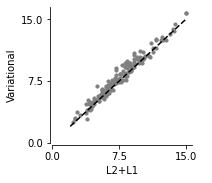

In [132]:
# compare
fig, ax = plt.subplots(figsize=(2.5,2.5))
i=1
ax.scatter(activations_rcnn.flatten(), activations_vcnn_false.flatten(),s=10,c='gray')
ax.plot([2,15], [2,15], ls='--',c='k')
ax.set_xticks([0, 7.5, 15])
ax.set_yticks([0, 7.5, 15])
ax.set_xlabel('L2+L1')
ax.set_ylabel('Variational')
ax.legend(loc='best',frameon=False)
handles, labels = ax.get_legend_handles_labels()
adjust_spines(ax, ['left', 'bottom'])
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/scatter_activation_max_seed1.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [131]:
temp=np.zeros(161)
for ii in range(161):
    temp[ii]=activations_vcnn_false[ii]-activations_rcnn[ii]
len([i for i  in temp if i >0])

122

## Load data

In [5]:
activations_neuron95_rcnn=np.zeros([5,161])
RF_neuron95_rcnn=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron95_rcnn[i]=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
    activations_neuron95_rcnn[i]=np.load('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_rcnn_Franke2021.npy')

    
activations_neuron123_rcnn=np.zeros([5,161])
RF_neuron123_rcnn=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron123_rcnn[i]=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
    activations_neuron123_rcnn[i]=np.load('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_rcnn_Franke2021.npy')

    
activations_neuron95_vcnn_false=np.zeros([5,161])
RF_neuron95_vcnn_false=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron95_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
    activations_neuron95_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')

    
activations_neuron123_vcnn_false=np.zeros([5,161])
RF_neuron123_vcnn_false=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron123_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
    activations_neuron123_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')

    
activations_neuron95_vcnn_true=np.zeros([5,100,1,161])
RF_neuron95_vcnn_true=np.zeros([5,100,1,2,36,64])
for i in range(5):
    RF_neuron95_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
    activations_neuron95_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')

activations_neuron123_vcnn_true=np.zeros([5,100,1,161])
RF_neuron123_vcnn_true=np.zeros([5,100,1,2,36,64])
for i in range(5):
    RF_neuron123_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
    activations_neuron123_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')

In [64]:
print("neuron 95:")
print("rcnn:",activations_neuron95_rcnn[:,95])
print("vcnn_f:",activations_neuron95_vcnn_false[:,95])
print("vcnn_t  mean of 100 sample:", np.mean(activations_neuron95_vcnn_true[:,:,:,95],axis=1).squeeze())
print("vcnn_t  mean of 20 sample:", np.mean(activations_neuron95_vcnn_true[:,:20,:,95],axis=1).squeeze())
print("vcnn_t  max of 100 sample:", np.max(activations_neuron95_vcnn_true[:,:,:,95],axis=1).squeeze())
print("vcnn_t  max of 20 sample:", np.max(activations_neuron95_vcnn_true[:,:20,:,95],axis=1).squeeze())


print("neuron 123:")
print(activations_neuron123_rcnn[:,123])
print(activations_neuron123_vcnn_false[:,123])
print("vcnn_t mean of 100 sample:",np.mean(activations_neuron123_vcnn_true[:,:,:,123],axis=1).squeeze())
print("vcnn_t mean of 20 sample:",np.mean(activations_neuron123_vcnn_true[:,:20,:,123],axis=1).squeeze())
print("vcnn_t  max of 100 sample:", np.max(activations_neuron123_vcnn_true[:,:,:,123],axis=1).squeeze())
print("vcnn_t  max of 20 sample:", np.max(activations_neuron123_vcnn_true[:,:20,:,123],axis=1).squeeze())

neuron 95:
rcnn: [ 9.36610413 11.33405113  9.13478661  9.33824253 11.05596638]
vcnn_f: [11.46407318 12.4668045  11.85247707 12.35008144  9.47778797]
vcnn_t  mean of 100 sample: [10.34924222 10.99529485 10.01387681 10.23548036  8.47881441]
vcnn_t  mean of 20 sample: [10.35805292 11.01877675 10.05815997 10.08481691  8.48384345]
vcnn_t  max of 100 sample: [11.14703369 11.96807098 11.01191235 11.58817577 11.41462231]
vcnn_t  max of 20 sample: [10.83459663 11.96807098 10.8782692  11.27744579 10.70974255]
neuron 123:
[10.69647312 11.3203392  11.18883228 11.05544281 11.73458195]
[10.62659454 11.53069592 11.01009369 11.2011795  10.53444004]
vcnn_t mean of 100 sample: [ 9.92261716 10.52637919 10.0611161  10.25853663  9.52670456]
vcnn_t mean of 20 sample: [ 9.96781564 10.58368616  9.99091411 10.21796021  9.52421393]
vcnn_t  max of 100 sample: [10.85474205 11.34074497 10.85150909 11.0474081  10.63217545]
vcnn_t  max of 20 sample: [10.80373478 11.34074497 10.5520649  11.0474081  10.34209728]


In [65]:
tempotput=np.mean(RF_neuron95_rcnn,axis=0)
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

unit=95
temprf= tempotput  
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Neuron {unit} activation: {tempact[0, unit]}')


(1, 2, 36, 64)
Neuron 95 activation: 10.129783630371094


In [66]:
tempotput=np.mean(RF_neuron95_vcnn_false,axis=0)
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

unit=95
temprf= tempotput  
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Neuron {unit} activation: {tempact[0, unit]}')

(1, 2, 36, 64)
Neuron 95 activation: 11.55065631866455


In [68]:
tempotput=np.mean(RF_neuron95_vcnn_true,axis=(0,1))
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

unit=95
temprf= tempotput  
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Neuron {unit} activation: {tempact[0, unit]}')

(1, 2, 36, 64)
Neuron 95 activation: 10.001091003417969


(5, 2, 36, 64)


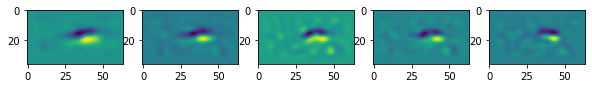

In [63]:
rf_mean_neuron95= np.mean(RF_neuron95_vcnn_true,axis=1).squeeze()
print(rf_mean_neuron95.shape)

fig,ax=plt.subplots(nrows=1, ncols=5, figsize=(10,4))
ax[0].imshow(rf_mean_neuron95[0,0])
ax[1].imshow(rf_mean_neuron95[1,0])
ax[2].imshow(rf_mean_neuron95[2,0])
ax[3].imshow(rf_mean_neuron95[3,0])
ax[4].imshow(rf_mean_neuron95[4,0])

(5, 2, 36, 64)


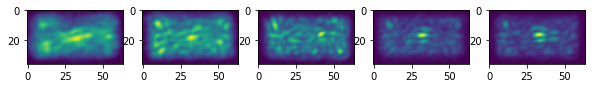

In [54]:
rf_std_neuron95=np.std(RF_neuron95_vcnn_true,axis=1,ddof=1).squeeze()
print(rf_std_neuron95.shape)

fig,ax=plt.subplots(nrows=1, ncols=5, figsize=(10,4))
ax[0].imshow(rf_std_neuron95[0,0])
ax[1].imshow(rf_std_neuron95[1,0])
ax[2].imshow(rf_std_neuron95[2,0])
ax[3].imshow(rf_std_neuron95[3,0])
ax[4].imshow(rf_std_neuron95[4,0])

(5, 2, 36, 64)


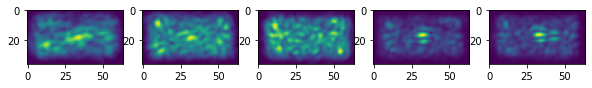

In [58]:
rf_std_neuron95=np.std(RF_neuron95_vcnn_true[:,:20],axis=1,ddof=1).squeeze()
print(rf_std_neuron95.shape)

fig,ax=plt.subplots(nrows=1, ncols=5, figsize=(10,4))
ax[0].imshow(rf_std_neuron95[0,0])
ax[1].imshow(rf_std_neuron95[1,0])
ax[2].imshow(rf_std_neuron95[2,0])
ax[3].imshow(rf_std_neuron95[3,0])
ax[4].imshow(rf_std_neuron95[4,0])

In [59]:
tempotput=np.mean(RF_neuron95_vcnn_true,axis=1)
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(5):
    unit=95
    temprf= tempotput[i]    
    tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Neuron {unit} activation: {tempact[0, unit]}')
 

(5, 1, 2, 36, 64)
Neuron 95 activation: 10.364192962646484
Neuron 95 activation: 11.079753875732422
Neuron 95 activation: 10.171868324279785
Neuron 95 activation: 10.132164001464844
Neuron 95 activation: 8.017132759094238


In [26]:
tempotput=np.mean(RF_neuron123_vcnn_true,axis=1)
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(5):
    unit=123
    temprf= tempotput[i]    
    tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Neuron {unit} activation: {tempact[0, unit]}')
 

Neuron 123 activation: 9.687178611755371
Neuron 123 activation: 10.232026100158691
Neuron 123 activation: 9.748725891113281
Neuron 123 activation: 9.948089599609375
Neuron 123 activation: 9.130724906921387


# try

### plosCBrebuttal

#### plot 6 neuon 

In [8]:
tempact95=np.load('out_20220423/MEIinput_activation-neuron95.npy')
tempact123=np.load('out_20220423/MEIinput_activation-neuron123.npy')
tempact106=np.load('out_20220423/MEIinput_activation-neuron106.npy')
tempact61=np.load('out_20220423/MEIinput_activation-neuron61.npy')
tempact52=np.load('out_20220423/MEIinput_activation-neuron52.npy')
tempact101=np.load('out_20220423/MEIinput_activation-neuron101.npy')

In [9]:
print(tempact95.shape)

(100, 1, 161)


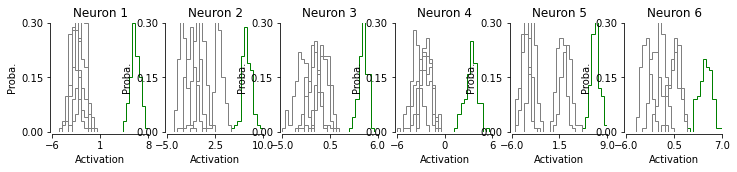

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=6,figsize=(12,2))

weights = np.ones_like(tempact95[:,:,95].flatten())/float(len(tempact95[:,:,95].flatten()))
vmin, vmax = -6,8 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[0].hist(tempact95[:,:,95].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact123[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact106[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact61[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact52[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact101[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].set_xlabel('Activation')
axes[0].set_ylabel('Proba.')
axes[0].set_xlim(-6,8)
axes[0].set_xticks([-6,1,8])
axes[0].set_ylim(0,0.3)
axes[0].set_yticks([0,0.15,0.3])
axes[0].set_title('Neuron 1') 
adjust_spines(axes[0], ['left', 'bottom'])


weights = np.ones_like(tempact123[:,:,123].flatten())/float(len(tempact123[:,:,123].flatten()))
vmin, vmax = -5,10 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[1].hist(tempact123[:,:,123].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact95[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact106[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact61[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact52[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact101[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].set_xlabel('Activation')
axes[1].set_ylabel('Proba.')
axes[1].set_xlim(-5,10)
axes[1].set_xticks([-5,2.5,10])
axes[1].set_ylim(0,0.3)
axes[1].set_yticks([0,0.15,0.3])
axes[1].set_title('Neuron 2') 
adjust_spines(axes[1], ['left', 'bottom'])



weights = np.ones_like(tempact106[:,:,106].flatten())/float(len(tempact106[:,:,106].flatten()))
vmin, vmax = -5,6 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[2].hist(tempact106[:,:,106].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact95[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact123[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact61[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact52[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact101[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].set_ylabel('Proba.')
axes[2].set_xlim(-5,6)
axes[2].set_xticks([-5,0.5,6])
axes[2].set_ylim(0,0.3)
axes[2].set_yticks([0,0.15,0.3])
axes[2].set_title('Neuron 3') 
adjust_spines(axes[2], ['left', 'bottom'])


weights = np.ones_like(tempact61[:,:,61].flatten())/float(len(tempact61[:,:,61].flatten()))
vmin, vmax = -6,6 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[3].hist(tempact61[:,:,61].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact95[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact123[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact106[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact52[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact101[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].set_xlabel('Activation')
axes[3].set_ylabel('Proba.')
axes[3].set_xlim(-6,6)
axes[3].set_xticks([-6,0,6])
axes[3].set_ylim(0,0.3)
axes[3].set_yticks([0,0.15,0.3])
axes[3].set_title('Neuron 4') 
adjust_spines(axes[3], ['left', 'bottom'])



weights = np.ones_like(tempact52[:,:,52].flatten())/float(len(tempact52[:,:,52].flatten()))
vmin, vmax = -6,9 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[4].hist(tempact52[:,:,52].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact95[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact123[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact106[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact61[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact101[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].set_xlabel('Activation')
axes[4].set_ylabel('Proba.')
axes[4].set_xlim(-6,9)
axes[4].set_xticks([-6,1.5,9])
axes[4].set_ylim(0,0.3)
axes[4].set_yticks([0,0.15,0.3])
axes[4].set_title('Neuron 5') 
adjust_spines(axes[4], ['left', 'bottom'])


weights = np.ones_like(tempact101[:,:,101].flatten())/float(len(tempact101[:,:,101].flatten()))
vmin, vmax = -6,7 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[5].hist(tempact101[:,:,101].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact95[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact123[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact106[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact61[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact52[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].set_xlabel('Activation')
axes[5].set_ylabel('Proba.')
axes[5].set_xlim(-6,7)
axes[5].set_xticks([-6,0.5,7])
axes[5].set_ylim(0,0.3)
axes[5].set_yticks([0,0.15,0.3])
axes[5].set_title('Neuron 6') 
adjust_spines(axes[5], ['left', 'bottom'])


#fig.savefig('out_result_20220423/try_3.svg')

## 30 neurons MEIs

In [24]:
example_30_neuron=[20,23,26,28,35,41,42,47,48,52,55,59,61,77,78,97,98,101,103,104,106,110,113,114,116,122,128,131,132,141]
print(len(example_30_neuron))

30


### L2+L1

In [25]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for neuron_i in example_30_neuron:
    for i in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
        torch.manual_seed(seeds[i])    # reproducible
        torch.cuda.manual_seed(seeds[i])
        unit = neuron_i
        inputseed = 1
        sampleFlag = False
        sampleseed = 1
        output = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        outputs_rcnn=np.array(output.cpu().data.numpy())
        outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
        #np.save('out_20220423/activation-max-example-neuron'+str(neuron_i)+'-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy', outputs_rcnn)
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

        outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
        out_rcnn = np.copy(outs)
        #np.save('out_20220423/activation-max-example-neuron'+str(neuron_i)+'-acts_seed_'+str(i)+'_rcnn_Franke2021.npy', out_rcnn)

outs.shape: (1, 161). Neuron 20 activation: 4.080655574798584
Test activation: outs.shape: (1, 161). Neuron 20 activation: 5.811005592346191
outs.shape: (1, 161). Neuron 20 activation: 5.9401679039001465
Test activation: outs.shape: (1, 161). Neuron 20 activation: 6.401888370513916
outs.shape: (1, 161). Neuron 20 activation: 6.1413397789001465
Test activation: outs.shape: (1, 161). Neuron 20 activation: 6.709632873535156
outs.shape: (1, 161). Neuron 20 activation: 5.713407516479492
Test activation: outs.shape: (1, 161). Neuron 20 activation: 6.2075018882751465
outs.shape: (1, 161). Neuron 20 activation: 10.703073501586914
Test activation: outs.shape: (1, 161). Neuron 20 activation: 5.318004608154297
outs.shape: (1, 161). Neuron 23 activation: 4.202419757843018
Test activation: outs.shape: (1, 161). Neuron 23 activation: 6.993694305419922
outs.shape: (1, 161). Neuron 23 activation: 7.721810340881348
Test activation: outs.shape: (1, 161). Neuron 23 activation: 8.221909523010254
outs.shap

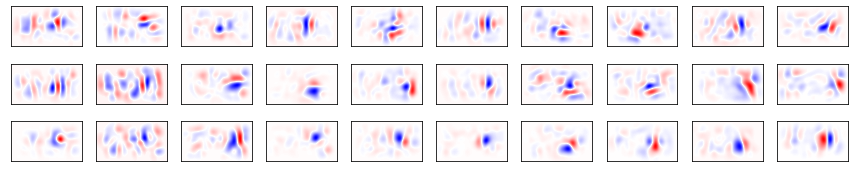

In [30]:
seed_i=1
nrows,ncols=3,10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
for ii in range(3):
    for jj in range(10):
        RF_fl_np=np.load('out_20220423/activation-max-example-neuron'+str(example_30_neuron[ii*10+jj])+'-outputs_seed_'+str(seed_i)+'_rcnn_Franke2021.npy')
        temp=RF_fl_np[0,0]
        tempmax=np.max(np.abs(RF_fl_np[0,0]))
        axes[ii][jj].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[ii][jj].grid(False)#axes[ii,jj].axis('tight')
        axes[ii][jj].set_xticks([])
        axes[ii][jj].set_yticks([])
        
#fig.savefig('out_result_20220423/RFs_with_std_rCNN_channel0_neuron_example30neurons_activation_max.svg')        

### VCNN

In [28]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for neuron_i in example_30_neuron:
    for i in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(i)+'.pth'))
        torch.manual_seed(seeds[i])    # reproducible
        torch.cuda.manual_seed(seeds[i])
        unit = neuron_i
        inputseed = 1
        sampleFlag = False
        sampleseed = 1
        output = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        outputs_vcnn=np.array(output.cpu().data.numpy())
       # np.save('out_20220423/activation-max-example-neuron'+str(neuron_i)+'-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', outputs_vcnn)
        outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

        outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
        out_vcnn = np.copy(outs)
        #np.save('out_20220423/activation-max-example-neuron'+str(neuron_i)+'-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy', out_vcnn)

outs.shape: (1, 161). Neuron 20 activation: 4.258244514465332
Test activation: outs.shape: (1, 161). Neuron 20 activation: 5.8385772705078125
outs.shape: (1, 161). Neuron 20 activation: 8.130142211914062
Test activation: outs.shape: (1, 161). Neuron 20 activation: 6.751664161682129
outs.shape: (1, 161). Neuron 20 activation: 17.481630325317383
Test activation: outs.shape: (1, 161). Neuron 20 activation: 6.679203987121582
outs.shape: (1, 161). Neuron 20 activation: 12.07886028289795
Test activation: outs.shape: (1, 161). Neuron 20 activation: 6.394430160522461
outs.shape: (1, 161). Neuron 20 activation: 15.365721702575684
Test activation: outs.shape: (1, 161). Neuron 20 activation: 5.829275131225586
outs.shape: (1, 161). Neuron 23 activation: 3.2901690006256104
Test activation: outs.shape: (1, 161). Neuron 23 activation: 7.791594982147217
outs.shape: (1, 161). Neuron 23 activation: 10.27347183227539
Test activation: outs.shape: (1, 161). Neuron 23 activation: 8.529263496398926
outs.shap

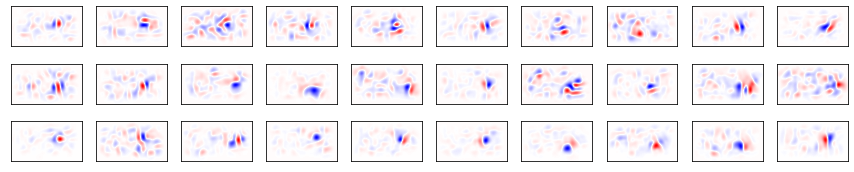

In [32]:
seed_i=1
nrows,ncols=3,10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
for ii in range(3):
    for jj in range(10):
        RF_fl_np=np.load('out_20220423/activation-max-example-neuron'+str(example_30_neuron[ii*10+jj])+'-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
        temp=RF_fl_np[0,0]
        tempmax=np.max(np.abs(RF_fl_np[0,0]))
        axes[ii][jj].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[ii][jj].grid(False)#axes[ii,jj].axis('tight')
        axes[ii][jj].set_xticks([])
        axes[ii][jj].set_yticks([])
        
#fig.savefig('out_result_20220423/RFs_with_std_vCNN_channel0_neuron_example30neurons_activation_max.svg')        